__[Open and try this file online (Colab)](https://colab.research.google.com/github/djekra/wiktionary_wortschatz/blob/master/1_wiktionary_parsen/x34_d01_tag_und_member.ipynb)__

# tag und member
* speichert in data_01
* 17 min
* lex_test level 1
-----


* erstellt die Felder tag und member 
* integriert lexeme_manuell und named_entities
* Löschen laut löschliste
* behandelt Partizipien

* erstellt dort wiktionary_lemma und wiktionary_nolemma
* wiktionary ist danach überflüssig


### Doku
* __Abkürzungen__ stehen immer in wiktionary_merkmal (merkmal abk) und manchmal auch als eigenständiges Lemma in wiktionary_lemma.
  In wiktionary_lemma werden Abkürzungen durch das member 'Abkürzung' gekennzeichnet. 
  Das gibt die Information, dass es sich lohnt, in wiktionary_merkmal nachzuschlagen, um die Bedeutung einer Abkürzung zu erfahren.

* __Partizipien__ stehen in wiktionary_merkmal. Ihr lemma ist das Verb im Infinitiv (das ist oft falsch eingetragen). Ihr tag lautet 'VVPP ADJA' für Ptz2 bzw. 'VVFIN ADJA' für Ptz1, ihr member ist Ptz1 bzw. Ptz2.
  Zusätzlich sind alle Partizipien aber auch als Adjektiv als eigenständiges lemma registriert. Dort weist data_id auf das Verb zurück.
  
### TODO 
* named_entities: section_id2 von existierenden Einträgen übertragen

  
### TODO Ganz am Ende, wenn alles komplett fertig ist:
* TODO_verwaiste_Wörter: Wichtige Wörter nachverfolgen. 
* TODO_TAGS_IN_MERKMALE: Sind diese Lexeme im Endergebnis enthalten? Gehören die nicht in wiktionary_nolemma??
* TODO_MEMBER_ÜBERPRÜFEN: Sind diese Informationen im Endergebnis enthalten?
* TODO_Widersprüchliche_Angaben

## Import

In [1]:
# blab init
try:
    import blab
except ImportError as e:
    !pip install blab
    import blab    
startup_notebook = blab.blab_startup()
%run $startup_notebook 

blab init
environment['in_colab']     = False
environment['dropbox_path'] = /home/me/Data_Linux/Dropbox
environment['lib_path']     = /home/me/Data_Linux/Dropbox/31_Projekte/01_Python/libs
Start Time: 20:25:17


In [2]:
# alle anderen
try:
    import pandasklar as pak, bpyth as bpy, bj_nlp

except ImportError as e:
    !pip install pandasklar bj_nlp
    import pandasklar as pak, bpyth as bpy, bj_nlp
    
grid       = pak.grid
check_mask = pak.check_mask      

## Einstellungen

In [3]:
# Einstellungen

# Was debuggen?
suche_debug = ['gefriergetrocknet','gefriertrocknen','missraten']  

gründlich          = True    # einige Arbeitsschritte können weggelassen werden, wenn gründlich = False
speicher_freigeben = False    # sollen alte Ergebnisse gelöscht werden
version            = '_all'
#version           = '_100K'




# verbose
pak.Config.set('VERBOSE', True)

# Load
verzeichnis_load                      = 'data_00'
wiktionary_filename                   = verzeichnis_load + '/wiktionary'              + version + '.pickle'  
wiktionary_trash_filename             = verzeichnis_load + '/wiktionary_trash'        + version + '.pickle'
wiktionary_merkmal_filename           = verzeichnis_load + '/wiktionary_merkmal'      + version + '.pickle'  
wiktionary_merkmal_text_filename      = verzeichnis_load + '/wiktionary_merkmal_text' + version + '.pickle'  

# Steuertabellen, externe und manuelle Daten
löschliste_filename                   = 'Steuertabellen/löschliste.xlsx'     
lexeme_manuell_filename               = 'Steuertabellen/lexeme_manuell.xlsx'       # manuell eingepflegte Lexeme 
named_entities_filename               = 'Steuertabellen/named_entities_02.xlsx'    # Vornamen, Nachnamen, Orte
lex_test_filename                     = 'Steuertabellen/lex_test.xlsx'     

# Save
verzeichnis_save                      = 'data_01'
wiktionary_lemma_filename_save        = verzeichnis_save + '/wiktionary_lemma'        + version + '.pickle'  
wiktionary_nolemma_filename_save      = verzeichnis_save + '/wiktionary_nolemma'      + version + '.pickle'  
wiktionary_merkmal_filename_save      = verzeichnis_save + '/wiktionary_merkmal'      + version + '.pickle'  
wiktionary_merkmal_text_filename_save = verzeichnis_save + '/wiktionary_merkmal_text' + version + '.pickle'  

#
# Einige hardcodierte Tags finden sich unter wiktionary Einzelkorrekturen
# !!!

VERBOSE = True
--> setting verbose=True as default for all pandasklar functions



## Vorbereiten

In [4]:
# Verzeichnisse erzeugen
os.makedirs(verzeichnis_load, exist_ok=True) 
os.makedirs(verzeichnis_save, exist_ok=True) 

In [5]:
# Steuertabellen und Python-Files von Github herunterladen
import os
if not os.path.exists('Steuertabellen'):
   !git clone https://github.com/djekra/wiktionary_wortschatz.git
   !cp -r wiktionary_wortschatz/1_wiktionary_parsen/Steuertabellen Steuertabellen
   !cp -r wiktionary_wortschatz/1_wiktionary_parsen/*.py .
#   !rm -r wiktionary_wortschatz

In [6]:
# Lade Ergebnisse der vorherigen Verarbeitungsstufe von Google Drive, falls nicht lokal vorhanden
# Dieses Verzeichnis wurde in der vorherigen Verarbeitungsstufe angelegt 
if environment['in_colab']:
    from google.colab import drive
    drive.mount('/content/drive') 
    !cd /content
    !cp -av /content/drive/MyDrive/{verzeichnis_load} .

In [389]:
# Weitere Imports
from x32_Funktionen                    import *
from Steuertabellen.s01_Steuertabellen import *
from collections                       import defaultdict

## Daten laden

In [8]:
# wiktionary laden     
wiktionary               = pak.load_pickle(wiktionary_filename)
wiktionary               = pak.drop_cols(wiktionary,['wikitext','section_id'])

wiktionary_trash         = pak.load_pickle(wiktionary_trash_filename)
wiktionary_trash         = pak.drop_cols(wiktionary_trash,['msg','section_id','wikitext'])
wiktionary_trash         = pak.rename_col(wiktionary_trash,'error','msg')

wiktionary_merkmal       = pak.load_pickle(wiktionary_merkmal_filename)
wiktionary_merkmal       = pak.drop_cols(wiktionary_merkmal,['section_id'])

wiktionary_merkmal_trash = wiktionary_merkmal.head(0)

wiktionary_merkmal_text  = pak.load_pickle(wiktionary_merkmal_text_filename)

837593 rows loaded
4152 rows loaded
5171417 rows loaded
654677 rows loaded


In [9]:
# laden

# pak.nnan(wiktionary_merkmal_text)

In [10]:
# Keine NaN
assert not pak.any_nan(wiktionary, without=['syllables','rhymes','flexion','ipa'])

In [11]:
# Keine Leerzeichen in der ID
mask = wiktionary.section_id2.str.contains(' ')
check_mask(wiktionary,mask,0)

check_mask:  0 rows


In [12]:
pak.memory_consumption(locals())

,name,rtype,size
0,wiktionary_merkmal,"(DataFrame, Series)",2.1 GB
1,wiktionary,"(DataFrame, Series)",769.9 MB
2,wiktionary_merkmal_text,"(DataFrame, Series)",326.5 MB
3,wiktionary_trash,"(DataFrame, Series)",4.0 MB
4,mask,"(Series,)",1.6 MB
5,translate_tag,"(DataFrame, Series)",37.1 KB
6,translate_tagZ,"(DataFrame, Series)",20.9 KB
7,_i3,"(str,)",3.8 KB
8,Stop,"(type,)",1.0 KB
9,Markdown,"(type,)",1.0 KB


### wiktionary anschauen

In [13]:
# suche_debug 
mask = wiktionary.title.isin(suche_debug)
grid(wiktionary[mask].sort_values(['section_id2',]))

3 rows


In [14]:
# suche_debug 
mask = wiktionary_trash.title.isin(suche_debug)
grid(wiktionary_trash[mask].sort_values(['section_id2',]))

No rows


In [15]:
# wiktionary_trash
a = pak.analyse_freqs(wiktionary_trash, 'msg')
a

,msg,msg_count,msg_percent,graph
0,title zu viele Wörter,3910,94.2,###############################################
1,title zu kurz,206,5.0,##
2,lemma zu kurz,26,0.6,
3,lang_code ist nan,10,0.2,


### wiktionary_merkmal anschauen

In [16]:
# suche_debug 
mask = wiktionary_merkmal.data.isin(suche_debug)
grid(wiktionary_merkmal[mask].sort_values(['section_id2','merkmal']))

164 rows


In [17]:
pak.analyse_cols(wiktionary_merkmal)

,col_name,datatype_instance,datatype,datatype_short,datatype_suggest,is_numeric,is_string,is_hashable,nan_allowed,mem_usage,ntypes,nunique,nnan,ndups,n,vmin,vmean,vmedian,vmax,vsum
0,__index__,int64,np.int64,int64,np.int32,True,False,True,False,80.0 B,1,5171417,0,0,5171417,0.0,2585708.0,2585708.0,5171416.0,1.337177e+13
1,section_id2,str,pd.string,string,,False,True,True,True,770.0 B,1,836708,0,4334709,5171417,&c.,NaN,NaN,μm,NaN
2,merkmal,str,pd.string,string,,False,True,True,True,717.0 B,1,36,0,5171381,5171417,Präfix,NaN,NaN,übersicht,NaN
3,node_debug,str,pd.string,string,,False,True,True,True,729.0 B,1,31,11465,5159921,5171417,,NaN,NaN,Wortart fehlt,NaN
4,node_kontext,str,pd.string,string,,False,True,True,True,609.0 B,1,235,11465,5159717,5171417,,NaN,NaN,Ü,NaN
5,data,str,pd.string,string,,False,True,True,True,756.0 B,1,725566,0,4445851,5171417,,NaN,NaN,𒄿𒌑𒃷,NaN
6,num,list,object,object,,False,True,False,True,464.0 B,1,224,1133103,4038090,5171417,[],NaN,NaN,[1225],NaN
7,meta,str,pd.string,string,,False,True,True,True,528.0 B,1,18571,1133103,4019743,5171417,,NaN,NaN,παθοs,NaN


In [18]:
pak.analyse_freqs(wiktionary_merkmal,['merkmal','data'])

,merkmal,merkmal_count,merkmal_percent,data,data_count
0,gm,2565289,49.6,"[überlegen, auserlesen, dunkelrot, praxisnah, ...","[243, 213, 199, 199, 197, 197, 195, 190, 185, ..."
1,übersicht,1121446,21.7,"[—, f, m, n, haben, -, –, sein, 1, 0, ja, , si...","[58205, 41060, 35808, 20346, 12628, 8656, 6524..."
2,def,290370,5.6,"[Deutschland, Stadt, Person, Vorname, Familien...","[2179, 2121, 1682, 1278, 928, 725, 514, 470, 4..."
3,familie,181434,3.5,"[Verzeichnis:Deutsch/Zahlenbegriffe, Adjektiv,...","[10, 9, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4,..."
4,down,170792,3.3,"[Sekunde, sein, Widder, Krebs, Löwe, Mutter, F...","[14, 14, 12, 11, 11, 11, 11, 11, 10, 10, 10, 1..."
5,kombi,153988,3.0,"[fahren, kommen, nach, leben, arbeiten, stamme...","[3663, 2081, 2015, 1975, 1929, 1909, 1905, 188..."
6,alt_1,147359,2.8,"[wandle, scharwenzle, scharwenzele, eiere, wan...","[12, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 1..."
7,syn,143937,2.8,"[machen, sehr, Unsinn, entfernen, Dummkopf, Ve...","[50, 44, 30, 28, 28, 27, 27, 27, 27, 26, 26, 2..."
8,up,111771,2.2,"[Stadt, Person, Frau, Pflanze, Tier, Sprache, ...","[2413, 780, 706, 582, 540, 491, 391, 357, 328,..."
9,lateral,110180,2.1,"[sein, lassen, machen, entfernen, nicht, versc...","[81, 81, 79, 66, 57, 51, 48, 47, 44, 41, 40, 3..."


In [19]:
# ursprüngliche_merkmale merken
ursprüngliche_merkmale = wiktionary_merkmal.merkmal.unique()

## Vorverarbeitung
* Feld num in String wandeln, um dups entfernen zu können
* Dups entfernen
* wiktionary: flexion in defaultdict wandeln

In [20]:
# num ist leere Liste 
mask = (wiktionary_merkmal.num.str.len() == 0)  
#wiktionary_merkmal[mask]
wiktionary_merkmal.loc[mask,'num'] = ''

In [21]:
# fillna
wiktionary_merkmal['num'] = wiktionary_merkmal.num.fillna('')

In [22]:
# num ist Liste mit einem Eintrag >> diesen verwenden
mask = (wiktionary_merkmal.num.str.len() == 1)
wiktionary_merkmal.loc[mask,'num'] = wiktionary_merkmal[mask].num.str[0]
#wiktionary_merkmal[mask]

In [23]:
?pak.list_to_string

Signature: pak.list_to_string(series, sep=',')
Docstring:
Converts a Series of lists of strings into a Series of strings.
* sep: The separator, default is ','
Example:
df = pak.people()
df['history2'] = pak.list_to_string(df.history)    
File:      ~/Data_Linux/Dropbox/31_Projekte/01_Python/git/pandasklar/src/pandasklar/pandas.py
Type:      function


In [24]:
# Liste in String wandeln, damit wir Dups entfernen können
# wiktionary_merkmal: list_to_string
wiktionary_merkmal['num'] = pak.list_to_string(wiktionary_merkmal.num)

In [25]:
# Dups entfernen. 
# Die Duplikate entstehen z.B. dadurch, dass für manche Merkmale nur der Linktext verwendet wird. 
# Beispiel Wolf_1, Merkmal kombi: die Wolf _mündet_, in die Wolf _mündet_ führt zu einem Duplikat.
mask = wiktionary_merkmal.duplicated()
wiktionary_merkmal = pak.drop_rows(wiktionary_merkmal, mask)

Delete 1902922 rows from 5171417


In [26]:
pak.analyse_cols(wiktionary_merkmal)

,col_name,datatype_instance,datatype,datatype_short,datatype_suggest,is_numeric,is_string,is_hashable,nan_allowed,mem_usage,ntypes,nunique,nnan,ndups,n,vmin,vmean,vmedian,vmax,vsum
0,__index__,int64,np.int64,int64,np.int32,True,False,True,False,80.0 B,1,3268495,0,0,3268495,0.0,2229677.05,2126302.0,5171413.0,7.287688e+12
1,section_id2,str,pd.string,string,,False,True,True,True,803.0 B,1,836708,0,2431787,3268495,&c.,NaN,NaN,μm,NaN
2,merkmal,str,pd.string,string,,False,True,True,True,677.0 B,1,36,0,3268459,3268495,Präfix,NaN,NaN,übersicht,NaN
3,node_debug,str,pd.string,string,,False,True,True,True,676.0 B,1,31,11465,3256999,3268495,,NaN,NaN,Wortart fehlt,NaN
4,node_kontext,str,pd.string,string,,False,True,True,True,593.0 B,1,235,11465,3256795,3268495,,NaN,NaN,Ü,NaN
5,data,str,pd.string,string,,False,True,True,True,750.0 B,1,725566,0,2542929,3268495,,NaN,NaN,𒄿𒌑𒃷,NaN
6,num,str,pd.string,string,,False,True,True,True,573.0 B,1,224,0,3268271,3268495,,NaN,NaN,"9,14",NaN
7,meta,str,pd.string,string,,False,True,True,True,536.0 B,1,18571,1133103,2116821,3268495,,NaN,NaN,παθοs,NaN


In [27]:
# lemma_lower
wiktionary['lemma_lower'] = wiktionary.lemma.str.lower() 

In [28]:
# wiktionary: flexion in defaultdict wandeln
# 1 min
wiktionary = pak.cols_to_defaultdict( wiktionary, col_dict='flexion')

<AxesSubplot: >

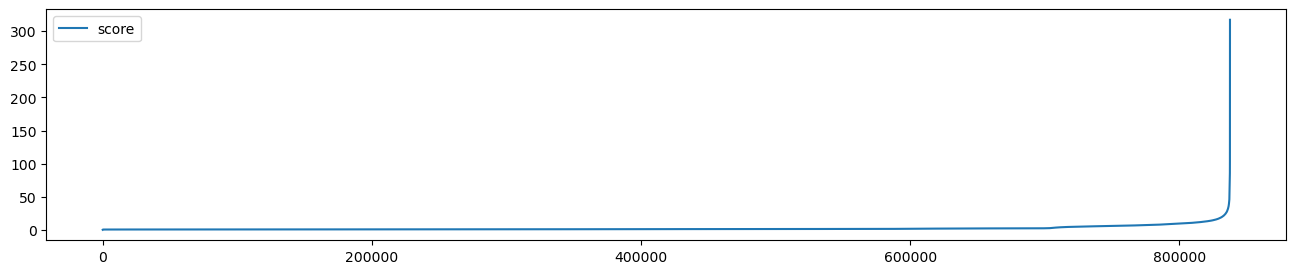

In [29]:
# section_len >> score
wiktionary = pak.rename_col(wiktionary,'section_len','score')

# page_part 0 aufwerten
mask = (wiktionary.lemma == wiktionary.section_id2)
wiktionary.loc[mask,'score'] = wiktionary[mask].score * 3

wiktionary['score'] = pak.scale( wiktionary.score, 'compare_median')
mask = wiktionary.score < 0.01
wiktionary.loc[mask,'score'] += 0.01

%matplotlib inline
a = wiktionary.score.sort_values().reset_index(drop=True)
pak.plot(a)

In [30]:
grid(wiktionary, pak.sample)

11 rows out of 837593


## Steuertabellen laden

In [31]:
blab.help(plan_merkmal_erstellen)

<class 'IPython.core.display.Markdown'>


<span style="font-size:larger;">plan_merkmal_erstellen():</span>

* definiert in Steuertabellen/s01_Steuertabellen.py
* `merkmal`: Name des Merkmals
* `template`: Name des Mediawiki-Templates, das diese Information enthält
* `collect`: Extractionsmethode
   * L extrahiert nur Links 
   * T extrahiert komplette Text-Absätze
   * Ü extrahiert Übersetzungen
   * P extrahiert Template-Parameter (Substring reicht)
   * E checkt nur auf Existenz
* `plan`:
   * 1: die Merkmale, die in wiktionary_merkmal gespeichert werden
   * 2: die Merkmale, die in wiktionary_merkmal_text gespeichert werden   
   * 3: Reihenfolge und Liste aller Merkmale aus flexion / übersicht <br>
        sowie die Merkmale aus named_entities und lexeme_manuell
* `sort`: Irgendwas zum Sortieren der Merkmale
* `is_lex`: Ist das Merkmal ein Lexem?    

In [390]:
# plan_merkmal Steuertabelle
try:
    del plan_merkmal
except:
    pass

from Steuertabellen.s01_Steuertabellen import *
plan_merkmal = plan_merkmal_erstellen()
grid(plan_merkmal)

103 rows


In [33]:
# translate_tag: Wortarten >> tags

try:
    del translate_tag
except:
    pass

from Steuertabellen.s01_Steuertabellen import *
grid(translate_tag)

179 rows


In [34]:
# translate_tagZ: tag >> tagZ und tagZZ

try:
    del translate_tagZ
except:
    pass

from Steuertabellen.s01_Steuertabellen import *
grid(translate_tagZ)

62 rows


In [35]:
# lex_test, lemma_test
lex_test, lemma_test = lade_lex_text( lex_test_filename, level=1)
grid(lemma_test)

80 rows loaded
Delete 21 rows from 80
48 rows


## Löschliste
* Excel-Datei aufbereiten
* wiktionary belöschen
* wiktionary_merkmal belöschen
* Falls löschliste und lexeme_manuell in Konflikt stehen, siegt lexeme_manuell. Es wird erst gelöscht und dann manuell ergänzt.

In [36]:
# Laden
löschliste = pak.load_excel( löschliste_filename )

379 rows loaded


In [37]:
# Format prüfen
löschliste['check'] = löschliste.isnull().sum(axis=1)
mask = löschliste.check != 2
error = check_mask(löschliste,mask,0, stop=False)
grid(löschliste,mask, color='green')

check_mask:  0 rows
No rows, mask filters them all away


In [38]:
löschliste = pak.drop_cols(löschliste,'check')
bpy.raise_if(error)

In [39]:
# Einzelne löschlisten

mask = löschliste.section_id2.notnull()
löschliste_section_id2 = list(löschliste[mask].drop_duplicates().section_id2)

mask = löschliste.lemma.notnull()
löschliste_lemma = list(löschliste[mask].drop_duplicates().lemma)

mask = löschliste.lex.notnull()
löschliste_lex = list(löschliste[mask].drop_duplicates().lex)
löschliste_lex += löschliste_lemma

In [40]:
# löschliste_lemma nach löschliste_section_id2 übertragen
mask1 =  wiktionary.title.isin(löschliste_lemma)   &   (wiktionary.title == wiktionary.lemma)
mask2 = ~wiktionary.section_id2.isin(löschliste_section_id2)
mask = mask1  &  mask2
#wiktionary[mask]
löschliste_section_id2 += list(wiktionary[mask].section_id2)

In [41]:
# wiktionary belöschen nach section_id2
mask = wiktionary.section_id2.isin(löschliste_section_id2)   
wiktionary, wiktionary_trash = pak.move_rows( df_from=wiktionary, df_to=wiktionary_trash, mask=mask, msg='löschliste_section_id2' )       # Löschen

Move 288 rows from 837593


In [42]:
# wiktionary belöschen nach lex
mask = wiktionary.title.isin(löschliste_lex)   
wiktionary, wiktionary_trash = pak.move_rows( df_from=wiktionary, df_to=wiktionary_trash, mask=mask, msg='löschliste_lex' )       # Löschen

Move 51 rows from 837305


In [43]:
# wiktionary_merkmal belöschen nach section_id2
mask = wiktionary_merkmal.section_id2.isin(löschliste_section_id2) 
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='löschliste_section_id2')

mask = wiktionary_merkmal_trash.msg == 'löschliste_section_id2'
grid(wiktionary_merkmal_trash,mask)

Move 3563 rows from 3268495
3563 rows


In [44]:
# wiktionary_merkmal belöschen nach lex
mask = wiktionary_merkmal.data.isin(löschliste_lex) 
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='löschliste_lex')

mask = wiktionary_merkmal_trash.msg == 'löschliste_lex'
grid(wiktionary_merkmal_trash,mask)

Move 655 rows from 3264932
655 rows out of 4218


In [45]:
# aufräumen
del löschliste_lemma
del löschliste

## wiktionary tag und member
* Aus dem Feld pos entstehen die Felder tag (standardisiert) und member (vollständig)

In [46]:
# Kaputte Datenstruktur in str wandeln
wiktionary['tag'] = wiktionary.pos.apply( lambda x: str(x) )
wiktionary = pak.move_cols(wiktionary,'tag','pos')

# translate
translate_chars = str.maketrans("{}'[]:", "     ,")
wiktionary.tag = wiktionary.tag.str.translate(translate_chars)

# Liste ohne Dups draus machen
wiktionary.tag = wiktionary.tag.str.split(",")
wiktionary.tag = wiktionary.tag.apply( lambda x: list(set(x)) )

# Strings pflegen
wiktionary.tag = wiktionary.tag.apply( lambda x: [ e.strip().replace(' ','_')  for e in x ] )

# Leere Strings entfernen
wiktionary.tag = wiktionary.tag.apply( lambda x: [ e for e in x  if e != ''] )

In [47]:
#grid(wiktionary, pak.sample)

In [48]:
# nach Priorität sortieren (laut Steuertabellen)
wiktionary.loc[:,'tag'] = member_sortieren(wiktionary.tag) 

In [49]:
# In string wandeln
wiktionary.tag = wiktionary.tag.str.join(' ')

In [50]:
# translate_first

print(translate_first1)
print(translate_first2)

wiktionary['tag'] = pak.replace_str( wiktionary.tag, translate_first1).str.strip()
wiktionary['tag'] = pak.replace_str( wiktionary.tag, translate_first2).str.strip()

[('  ', ' '), ('Partizip II', 'Ptz2'), ('Partizip_II', 'Ptz2'), ('PartizipII', 'Ptz2'), ('Konjunktiv II', 'Konj2'), ('Konjunktiv_II', 'Konj2'), ('KonjunktivII', 'Konj2'), ('  ', ' ')]
[('  ', ' '), ('Partizip I', 'Ptz1'), ('Partizip_I', 'Ptz1'), ('PartizipI', 'Ptz1'), ('Konjunktiv I', 'Konj1'), ('Konjunktiv_I', 'Konj1'), ('KonjunktivI', 'Konj1'), ('  ', ' ')]


In [51]:
#mask = (wiktionary.tag.str.count(' ') + 1)  > 2   
#wiktionary[mask]

In [52]:
grid(wiktionary, pak.sample)

11 rows out of 837254


In [53]:
pak.analyse_cols(wiktionary)

,col_name,datatype_instance,datatype,datatype_short,datatype_suggest,is_numeric,is_string,is_hashable,nan_allowed,mem_usage,ntypes,nunique,nnan,ndups,n,vmin,vmean,vmedian,vmax,vsum
0,__index__,int64,np.int64,int64,np.int32,True,False,True,False,80.0 B,1,837254,0,0,837254,0.0,418844.41,418843.5,837592.0,3.506792e+11
1,page_id,int64,np.int64,int64,pd.Int32,True,False,True,False,80.0 B,1,801783,0,35471,837254,0.0,622165.26,623174.5,1118318.0,5.209104e+11
2,page_part,int64,np.int64,int64,pd.Int8,True,False,True,False,80.0 B,1,7,0,837247,837254,0.0,0.04,0.0,6.0,3.743700e+04
3,section_id2,str,object,object,pd.string,False,True,True,True,782.0 B,1,837254,0,0,837254,&c.,NaN,NaN,μm,NaN
4,title,str,object,object,pd.string,False,True,True,True,782.0 B,1,801781,0,35473,837254,&c.,NaN,NaN,μm,NaN
5,lemma,str,object,object,pd.string,False,True,True,True,753.0 B,1,159400,0,677854,837254,&c.,NaN,NaN,μm,NaN
6,inflected,bool_,bool,bool,,True,False,True,True,10.0 B,1,2,0,837252,837254,0.0,0.83,NaN,1.0,6.968710e+05
7,pos,dict,object,object,,False,True,False,True,2.2 KB,1,161,0,837093,837254,NaN,NaN,NaN,NaN,NaN
8,tag,str,object,object,pd.string,False,True,True,True,719.0 B,1,155,0,837099,837254,Abkürzung,NaN,NaN,Wortverbindung Partikel,NaN
9,rhymes,list,object,object,,False,True,False,True,464.0 B,1,39528,526978,270748,837254,[a],NaN,NaN,"[ʏʃəs, yːʃəs]",NaN


In [54]:
# Spalte member bewahrt die ursprüngliche Klassifizierung vollständig
wiktionary['member'] = wiktionary.tag.copy()
wiktionary = pak.move_cols(wiktionary,'member','tag')

In [55]:
# wiktionary anschauen
#mask = wiktionary.tag == 'ADJA ADV PRO'
mask = wiktionary.title.isin( suche_debug )
grid(wiktionary,mask)

3 rows out of 837254


In [56]:
grid(translate_tag)

179 rows


In [57]:
# anwenden
wiktionary['tag'] = pak.replace_str( wiktionary.tag, translate_tag )
wiktionary['tag'] = wiktionary.tag.str.replace('  ',' ').str.strip()    

In [58]:
# Durchlauf2: translate_tag erneut anwenden 
mask = translate_tag.notiz.str.contains('Durchlauf2')
wiktionary['tag'] = pak.replace_str( wiktionary.tag, translate_tag[mask] )
wiktionary['tag'] = wiktionary.tag.str.replace('  ',' ').str.strip()    

In [59]:
# tag TODO für alles, was noch weiterverarbeitet werden muss
mask = (wiktionary.tag.str.len() == 0)
wiktionary.loc[mask,'tag'] = 'TODO'
#grid(wiktionary,mask)

In [60]:
# wiktionary anschauen
#mask = wiktionary.tag == 'ADJA ADV PRO'
mask = wiktionary.title.isin( suche_debug )
grid(wiktionary,mask)

3 rows out of 837254


In [61]:
# Dekliniertes_Gerundivum: beizubehaltende
# VMaßeinheiten

## Bindestrich

In [62]:
# Gebundene Adjektiv-Lexeme in wiktionary
suche = ['ober-','unter-','äußer-','inner-',]
mask = wiktionary.section_id2.isin(suche)
check_mask(wiktionary,mask,0,4)

wiktionary.loc[mask,'title']       = wiktionary[mask].title.str.replace('-','')
wiktionary.loc[mask,'lemma']       = wiktionary[mask].lemma.str.replace('-','')
wiktionary.loc[mask,'lemma_lower'] = wiktionary[mask].lemma_lower.str.replace('-','')
wiktionary.loc[mask,'member']      = 'Adjektiv'
wiktionary.loc[mask,'tag']         = 'ADJA'
wiktionary.loc[mask,'pos']         = {'Adjektiv': []}
wiktionary.loc[mask,'section_id2'] = wiktionary[mask].section_id2.str.replace('-','_glex')
wiktionary[mask]

check_mask:  4 rows


,page_id,page_part,section_id2,title,lemma,inflected,pos,tag,member,rhymes,score,flexion,ipa,syllables,lang,lang_code,error,lemma_lower
25872,68346,0,unter_glex,unter,unter,False,NaN,ADJA,Adjektiv,NaN,10.343864,{},[ʊntɐ],"[un, ter]",Deutsch,de,,unter
214016,380261,0,ober_glex,ober,ober,False,NaN,ADJA,Adjektiv,NaN,7.959903,{},[ˈoːbɐ],[ober],Deutsch,de,,ober
457256,681179,0,äußer_glex,äußer,äußer,False,NaN,ADJA,Adjektiv,NaN,12.086270,"{'Positiv': ['äußer(er)'], 'Superlativ': ['äuß...",[ˈɔɪ̯səʁɐ],NaN,Deutsch,de,,äußer
457269,681193,0,inner_glex,inner,inner,False,NaN,ADJA,Adjektiv,NaN,12.695018,"{'Positiv': ['inner(er)'], 'Superlativ': ['inn...",[ˈɪnɐ],NaN,Deutsch,de,,inner


In [63]:
# Gebundene Adjektiv-Lexeme in wiktionary_merkmal
suche = ['ober-','unter-','äußer-','inner-',]
mask = wiktionary_merkmal.section_id2.isin(suche)
check_mask(wiktionary_merkmal,mask,0,80)
wiktionary_merkmal.loc[mask,'section_id2'] = wiktionary_merkmal[mask].section_id2.str.replace('-','_glex')
#wiktionary_merkmal[mask]

check_mask:  80 rows


In [64]:
# Gebundene Adjektiv-Lexeme in wiktionary_merkmal_text
suche = ['ober-','unter-','äußer-','inner-',]
mask = wiktionary_merkmal_text.section_id2.isin(suche)
check_mask(wiktionary_merkmal_text,mask,0,46)
wiktionary_merkmal_text.loc[mask,'section_id2'] = wiktionary_merkmal_text[mask].section_id2.str.replace('-','_glex')
#wiktionary_merkmal_text[mask]

check_mask:  46 rows


In [65]:
# Gebundene Adjektiv-Lexeme in wiktionary
suche = ['ober-','unter-','äußer-','inner-',]
mask = wiktionary.lemma.isin(suche)
check_mask(wiktionary,mask,0,36)

wiktionary.loc[mask,'title']       = wiktionary[mask].title.str.replace('-','')
wiktionary.loc[mask,'lemma']       = wiktionary[mask].lemma.str.replace('-','')
wiktionary.loc[mask,'lemma_lower'] = wiktionary[mask].lemma_lower.str.replace('-','')
#grid(wiktionary,mask)

check_mask:  36 rows


In [66]:
# Gebundene Adjektiv-Lexeme in wiktionary_merkmal
suche = ['ober-','unter-','äußer-','inner-',]
mask = wiktionary_merkmal.data.isin(suche)
check_mask(wiktionary_merkmal,mask,0,10)
wiktionary_merkmal.loc[mask,'data'] = wiktionary_merkmal[mask].data.str.replace('-','')
wiktionary_merkmal[mask]

check_mask:  1 rows


,section_id2,merkmal,node_debug,node_kontext,data,num,meta
652252,unter-_1,übersicht,Deutsch Adjektiv Übersicht,Positiv,unter,,<NA>


In [67]:
# AFIX 588
mask0 = ~wiktionary.lemma.str.startswith('-')   
mask1 =  wiktionary.lemma.str.endswith('-')  
mask2 = ~wiktionary.lemma.str[0].str.isdigit()
mask3 =  wiktionary.lemma.str.len() > 1
mask4 = ~wiktionary.tag.str.contains(' ')   
mask = mask0  &  mask1  &  mask2  &  mask3  &  mask4 
pak.check_mask(wiktionary, mask, 0, 700)
#grid(wiktionary, mask)
#pak.analyse_freqs(wiktionary[mask], 'tag')
wiktionary.loc[ mask, 'tag'] = 'AFIX ' + wiktionary[mask].tag

check_mask:  551 rows


In [68]:
# ZFIX
mask0 =  wiktionary.lemma.str.startswith('-')
mask1 = ~wiktionary.lemma.str.endswith('-')
mask2 = ~wiktionary.lemma.str[-1].str.isdigit()
mask3 =  wiktionary.lemma.str.len() > 1
mask4 = ~wiktionary.tag.str.contains(' ')   
mask = mask0  &  mask1  &  mask2  &  mask3  &  mask4 
pak.check_mask(wiktionary, mask, 0, 600)
#grid(wiktionary, mask)
#pak.analyse_freqs(wiktionary[mask], 'tag')
wiktionary.loc[ mask, 'tag'] = 'ZFIX ' + wiktionary[mask].tag

check_mask:  480 rows


In [69]:
# MFIX >> löschen
mask0 =  wiktionary.lemma.str.startswith('-')
mask1 =  wiktionary.lemma.str.endswith('-') 
mask2 =  wiktionary.lemma.str.len() > 2
mask3 = ~wiktionary.tag.str.contains(' ')   
mask = mask0  &  mask1  &  mask2  &  mask3
check_mask(wiktionary, mask, 0, 4)
#grid(wiktionary, mask)
#analyse_freqs(wiktionary[mask], 'tag')
wiktionary, wiktionary_trash = pak.move_rows(df_from=wiktionary, df_to=wiktionary_trash, mask=mask, msg='MFIX') 

check_mask:  4 rows
Move 4 rows from 837254


## wiktionary Einzelkorrekturen

In [70]:
# Beispiele anzeigen
mask = wiktionary.member.str.contains('VMaßeinheiten')
grid(wiktionary,mask, color=None)

No rows, mask filters them all away


In [71]:
# anschauen
a = pak.analyse_freqs( wiktionary, ['member', 'tag'], splits=[' ',None])
grid(a)

68 rows


In [72]:
# Einzelkorrekturen        
einzelkorrekturen = { 'viel'        : 'ADJA PIAT',  # war: ADJA ADV PIAT CARD
                      'zig'         : 'ADJA',
                      'bis'         : 'KOUS APPR',      
                      'derentwegen' : 'PDAT PRELAT',
                      'Fachleute'   : 'NN',
                      'Rheinland'   : 'NE',                 
}
for i,t in einzelkorrekturen.items():
    mask = (wiktionary.section_id2 == i)
    wiktionary.loc[mask,'tag'] = t

In [73]:
# pflege_tag_felder (schreibe tagZZ usw.)
wiktionary = pflege_tag_felder(wiktionary, translate_tagZ)

## named_entities

In [74]:
# laden
named_entities = pak.load_excel(named_entities_filename, tabcol='quelle')

4544 rows loaded


In [75]:
# Überblick
a = pak.analyse_freqs(named_entities, cols=['quelle','member','lemma'], splits=[None,' '])
grid(a)

3 rows


In [76]:
# Felder ergänzen
named_entities['title']       = named_entities.lemma
named_entities['lemma_lower'] = named_entities.lemma.str.lower() 
named_entities = pak.move_cols( named_entities, 'lemma_lower','lemma')

In [77]:
# section_id2
named_entities['section_id2'] = named_entities.lemma + '_' + named_entities.quelle.str[0].str.upper().copy()
named_entities['section_id2'] = named_entities.section_id2.str.replace(' ','_').copy()
named_entities = pak.move_cols(named_entities, ['section_id2','title'])

In [78]:
# Bekannte section_id2 aus wiktionary übertragen. Aber nur wenn der tag wirklich gleich ist.
mask = (wiktionary.lemma == wiktionary.title)  # wichtig
named_entities = pak.update_col(named_entities, wiktionary[mask], on=['lemma_lower','tag'], col='section_id2',  col_score='score' )

update_col: col_score score applied, 2291 records less!
update_col: 1251 cells written into existing column


In [79]:
# drop_cols
named_entities = pak.drop_cols(named_entities,['sex_f', 'sex_m', 'Land', 'Stadt','quelle'])

In [80]:
# score erhöhen
named_entities.score += 1.0
named_entities.score *= 2.0

In [81]:
grid(named_entities, pak.sample)

7 rows out of 4544


In [82]:
# Dups?
mask = named_entities.section_id2.duplicated()
check_mask(named_entities,mask,0,0)

check_mask:  0 rows


In [83]:
?pak.cols_to_dict

Signature:
pak.cols_to_dict(
    df,
    col_dict='',
    cols_add=[],
    use_defaultdict=False,
    drop=True,
)
Docstring:
Moves columns into a dict or defaultdict.
This is 
* col_dict:         name of the target column. Can be empty, but may already contain a dict or defaultdict. 
* cols_add:         Columns to be packed.
* use_defaultdict:  Should a defaultdict be used as data structure? Otherwise keys can only occur once.
* drop:             Should the packed columns be dropped (>> move) or not (>> copy)?
File:      ~/Data_Linux/Dropbox/31_Projekte/01_Python/git/pandasklar/src/pandasklar/aggregate.py
Type:      function


In [84]:
named_entities = pak.cols_to_dict(named_entities,col_dict='flexion',cols_add=['Genus','Nom Sg','Gen Sg',], use_defaultdict=True)
named_entities

,section_id2,title,lemma,lemma_lower,tag,member,score,flexion
0,Hagen,Hagen,Hagen,hagen,NE,Vorname Nachname,2.989899,"{'Genus': ['m'], 'Nom Sg': ['Hagen'], 'Gen Sg'..."
1,Jordan,Jordan,Jordan,jordan,NE,Vorname Nachname,2.989899,"{'Genus': ['m'], 'Nom Sg': ['Jordan'], 'Gen Sg..."
2,Menzel_V,Menzel,Menzel,menzel,NE,Vorname Nachname,2.989899,"{'Genus': ['m'], 'Nom Sg': ['Menzel'], 'Gen Sg..."
3,Oswald_V,Oswald,Oswald,oswald,NE,Vorname Nachname,2.989899,"{'Genus': ['m'], 'Nom Sg': ['Oswald'], 'Gen Sg..."
4,Reinhardt_V,Reinhardt,Reinhardt,reinhardt,NE,Vorname Nachname,2.989899,"{'Genus': ['m'], 'Nom Sg': ['Reinhardt'], 'Gen..."
...,...,...,...,...,...,...,...,...
4539,Wolff,Wolff,Wolff,wolff,NE,Nachname,2.989899,"{'Nom Sg': ['Wolff'], 'Gen Sg': ['Wolffs']}"
4540,Wolter_N,Wolter,Wolter,wolter,NE,Nachname,2.989899,"{'Nom Sg': ['Wolter'], 'Gen Sg': ['Wolters']}"
4541,Zander_2,Zander,Zander,zander,NE,Nachname,2.989899,"{'Nom Sg': ['Zander'], 'Gen Sg': ['Zanders']}"
4542,Zeller_N,Zeller,Zeller,zeller,NE,Nachname,2.989899,"{'Nom Sg': ['Zeller'], 'Gen Sg': ['Zellers']}"


In [85]:
grid(named_entities, pak.sample)

5 rows out of 4544


In [86]:
# anfügen
wiktionary = pak.add_rows(wiktionary, named_entities, assert_subset=True)

4544 rows added, now a total of 841794


In [87]:
# flexion type korrekt?
assert pak.ntypes(wiktionary.flexion) == 1

In [88]:
# wiktionary anschauen
mask = wiktionary.title.isin(suche_debug) 
r = wiktionary[mask].sort_values(['title','section_id2'])
grid(r)

3 rows


## Zahlwörter

In [89]:
# Wandelt eine Zahl in Worte um
def zahl_in_worten(n, s=True, z=False):
    
    w1 = "null ein zwei drei vier fünf sechs sieben acht neun zehn elf zwölf dreizehn vierzehn fünfzehn sechzehn siebzehn achtzehn neunzehn".split()
    w2 = "zwanzig dreißig vierzig fünfzig sechzig siebzig achtzig neunzig".split()    
    if n < 0: raise ValueError
    if n == 0 and z: return ""
    if n == 1 and s: return "eins"
    if n < 20: return w1[n]
    if n < 100:
        w = w2[(n - 20) // 10]
        if n % 10:
            w = w1[n % 10] + "und" + w
        return w
    if n < 1000:
        return w1[n // 100] + "hundert" + zahl_in_worten(n % 100, z=True)
    if n < 1000000:
        return zahl_in_worten(n // 1000, s=False) + "tausend" + zahl_in_worten(n % 1000, z=True)
    raise ValueError

In [90]:
print(zahl_in_worten(3107))

dreitausendeinhundertsieben


In [91]:
def zahlwörter_liste(range_): 
    return [ 
    {'lex' : [zahl_in_worten(z), str(z)], 
     'lemma' : zahl_in_worten(z),      
     'def'   : str(z),
    } for z in range_]

zahlwörter_liste(range(0,20,10))

[{'lex': ['null', '0'], 'lemma': 'null', 'def': '0'},
 {'lex': ['zehn', '10'], 'lemma': 'zehn', 'def': '10'}]

In [92]:
# 0..99 zahlwörter_a erzeugen
range_ = range(0,100)
zahlwörter_a = pd.DataFrame(zahlwörter_liste( range_ ))
#zahlwörter_a

In [93]:
# Hunderter Zahlwörter erzeugen
range_ = range(100,1000,100)
zahlwörter_b = pd.DataFrame(zahlwörter_liste( range_ ))
#zahlwörter_b

In [94]:
# Tausender Zahlwörter erzeugen
range_ = range(1000,99001,1000)
zahlwörter_c = pd.DataFrame(zahlwörter_liste( range_ ))
#zahlwörter_c

In [95]:
# Zehntausender Zahlwörter erzeugen
range_ = range(10000,99001,10000)
zahlwörter_d = pd.DataFrame(zahlwörter_liste( range_ ))
#zahlwörter_d

In [96]:
# Hunderttausender Zahlwörter erzeugen
range_ = range(100000,990001,100000)
zahlwörter_e = pd.DataFrame(zahlwörter_liste( range_ ))
#zahlwörter_e

In [97]:
# concat
zahlwörter_all = pd.concat([  zahlwörter_a, zahlwörter_b, zahlwörter_c, zahlwörter_d, zahlwörter_e,  ])

In [98]:
# explode lex
zahlwörter_all = zahlwörter_all.explode('lex')

In [99]:
# Sonstige Spalten
zahlwörter_all['tag']         = 'CARD'
zahlwörter_all['tag_lex']     = 'lex' # ja
zahlwörter_all['genus']       = 'f'
zahlwörter_all['member']      = 'Zahlwort'
zahlwörter_all['tab']         = 'Zahlwort' # Wird später wieder gelöscht, dient der Kompatibilität zu lexeme_manuell

In [100]:
# Substantive ergänzen
mask = zahlwörter_all.lex == zahlwörter_all.lemma
df = zahlwörter_all[mask].copy()
df['lex']   = df.lex.str.capitalize()
df['lemma'] = df.lex.str.capitalize()
df['tag']   = 'NN'
zahlwörter_all = pak.add_rows(zahlwörter_all, df)
#df

226 rows added, now a total of 678


In [101]:
# zahlwörter_all anschauen
pak.sample(zahlwörter_all)

,lex,lemma,def,tag,tag_lex,genus,member,tab
0,null,null,0,CARD,lex,f,Zahlwort,Zahlwort
237,10000,zehntausend,10000,CARD,lex,f,Zahlwort,Zahlwort
376,achtzigtausend,achtzigtausend,80000,CARD,lex,f,Zahlwort,Zahlwort
677,Neunhunderttausend,Neunhunderttausend,900000,NN,lex,f,Zahlwort,Zahlwort


## lexeme_manuell

In [102]:
# laden
lexeme_manuell = pak.load_excel( lexeme_manuell_filename, tabcol='tab' )
lexeme_manuell = pak.move_cols(  lexeme_manuell, 'tag_lex')

1794 rows loaded


In [103]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,tag_lex,lex,lemma,tag,member,genus,tab
61,Ptz2,gefriergetrocknet,gefriertrocknen,VVFIN,<NA>,<NA>,Partizipien
90,Ptz2,mißraten,missraten,VVFIN,<NA>,<NA>,Partizipien
204,Ptz2,missraten,missraten,VVFIN,<NA>,<NA>,Partizipien


In [104]:
# Partizipien falsch definiert?
mask1  = lexeme_manuell.tag_lex.str.startswith('Ptz')
mask2A = lexeme_manuell.tab != 'Partizipien'
mask2B = lexeme_manuell.tag != 'VVFIN'
mask = mask1  &  (mask2A | mask2B)
check_mask(lexeme_manuell,mask,0)
#lexeme_manuell[mask]

check_mask:  0 rows


In [105]:
# Abkürzungen falsch definiert?
# Das Schlüsselwort 'Abkürzung' darf nirgends in lexeme_manuell vorkommen.
mask1A = lexeme_manuell.member.str.contains('Abkürzung')
mask1B = lexeme_manuell.member.str.contains('Abkürzung')
mask = (mask1A | mask1B) 
check_mask(lexeme_manuell,mask,0)
lexeme_manuell[mask]

check_mask:  0 rows


,tag_lex,lex,lemma,tag,member,genus,tab


In [106]:
pak.sample(zahlwörter_all)

,lex,lemma,def,tag,tag_lex,genus,member,tab
0,null,null,0,CARD,lex,f,Zahlwort,Zahlwort
237,10000,zehntausend,10000,CARD,lex,f,Zahlwort,Zahlwort
376,achtzigtausend,achtzigtausend,80000,CARD,lex,f,Zahlwort,Zahlwort
677,Neunhunderttausend,Neunhunderttausend,900000,NN,lex,f,Zahlwort,Zahlwort


In [107]:
# assert subset
assert set(zahlwörter_all.columns) - set(['def']) <= set(lexeme_manuell.columns)

In [108]:
# zahlwörter_all anfügen
lexeme_manuell = pak.add_rows(lexeme_manuell, zahlwörter_all)

678 rows added, now a total of 2472


In [109]:
# tab analysieren
pak.analyse_freqs( lexeme_manuell, cols='tab')

,tab,tab_count,tab_percent,graph
0,esszett,729,29.5,##############
1,Zahlwort,678,27.4,#############
2,Partizipien,414,16.7,########
3,Diverses,299,12.1,######
4,Abkuerzungen,156,6.3,###
5,FM,102,4.1,##
6,Symbole,48,1.9,
7,Partikel,44,1.8,
8,Namen,2,0.1,


In [110]:
# NaN

# def
lexeme_manuell['def'] = lexeme_manuell['def'].fillna('')

# member
mask = lexeme_manuell.member.isnull()   |   lexeme_manuell.member.isin(['nan'])
lexeme_manuell.loc[mask,'member'] = ''
lexeme_manuell.member += ' manuell'

# lemma und lex
mask = lexeme_manuell.lemma.isnull()   |   lexeme_manuell.lemma.isin(['nan',''])
lexeme_manuell.loc[mask,'lemma'] = lexeme_manuell[mask].lex
lexeme_manuell.loc[mask,'member'] += ' ergänzt'

mask = lexeme_manuell.lex.isnull()   |   lexeme_manuell.lex.isin(['nan',''])
lexeme_manuell.loc[mask,'lex'] = lexeme_manuell[mask].lemma
lexeme_manuell.loc[mask,'member'] += ' ergänzt'

# genus
mask = lexeme_manuell.genus.isnull()   |   lexeme_manuell.genus.isin(['nan'])
lexeme_manuell.loc[mask,'genus'] = ''

# tag_lex
mask = lexeme_manuell.tag_lex.isnull()   |   lexeme_manuell.tag_lex.isin(['nan'])
lexeme_manuell.loc[mask,'tag_lex'] = ''

mask = (lexeme_manuell.lex != lexeme_manuell.lemma)   &   (lexeme_manuell.tag_lex == '')
lexeme_manuell.loc[mask,'tag_lex'] = 'lex'

mask = (lexeme_manuell.lex == lexeme_manuell.lemma)   &   (  (lexeme_manuell.tag_lex == 'lex')  | (lexeme_manuell.tag_lex == '')  )
lexeme_manuell.loc[mask,'tag_lex'] = 'lemma'

# tag
mask = lexeme_manuell.tag.isnull()   |   lexeme_manuell.tag.isin(['nan',''])
check_mask( lexeme_manuell, mask, 0, 0)

# Abschluss
lexeme_manuell.member = lexeme_manuell.member.str.strip()
lexeme_manuell = pak.rename_col(lexeme_manuell, 'genus','Genus')

#lexeme_manuell = pak.move_cols(lexeme_manuell, ['Genus','abk'], -1)
#lexeme_manuell['abk'] = ''

check_mask:  0 rows


In [111]:
# Dups löschen
mask = lexeme_manuell.duplicated()
lexeme_manuell, df = pak.move_rows(lexeme_manuell,mask)
grid(df)

Move 104 rows from 2472
104 rows


In [112]:
pak.sample(lexeme_manuell)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
0,Ptz2,abberufen,abberufen,VVFIN,manuell,,Partizipien,
482,lex,Kids,Kid,NN,manuell,n,Diverses,
497,lex,musses,müssen,VMFIN,manuell,,Diverses,
554,ADV,zu viele,zu viel,ADV,manuell,,Diverses,
653,lemma,5G,5G,NN,manuell ergänzt,,Diverses,
713,lex,❀,_,$(,manuell,,Symbole,
715,syn,[,(,$(,manuell,,Symbole,
748,lemma,!,!,$.,manuell ergänzt,,Symbole,
751,lemma,…,…,$(,manuell ergänzt,,Symbole,
1014,lex,gewiß,gewiss,ADV,modal lexAlt manuell,,esszett,


In [113]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
61,Ptz2,gefriergetrocknet,gefriertrocknen,VVFIN,manuell,,Partizipien,
90,Ptz2,mißraten,missraten,VVFIN,manuell,,Partizipien,
204,Ptz2,missraten,missraten,VVFIN,manuell,,Partizipien,


In [114]:
# strip
for c in lexeme_manuell.columns:
    lexeme_manuell[c] = lexeme_manuell[c].str.replace('  ',' ').str.strip()

In [115]:
# member analysieren
pak.analyse_freqs( lexeme_manuell, cols='member', splits=' ')

,member,member_count,member_percent,graph
0,manuell,2368,57.1,############################
1,lexAlt,653,15.7,#######
2,Zahlwort,651,15.7,#######
3,ergänzt,345,8.3,####
4,Einheit,56,1.3,
5,PRE,42,1.0,
6,Wortverbindung,28,0.7,
7,Ort,2,0.0,
8,modal,1,0.0,
9,Land,1,0.0,


In [116]:
# Derzeit nicht nötig: Ersetzungen im member
r = {  'Partizip1'          :  'Ptz1',        
       'Partizip_1'         :  'Ptz1',       
       'Partizip2'          :  'Ptz2',        
       'Partizip_2'         :  'Ptz2',   
       'Abkürzungen'        :  'Abkürzung',      
       'Abkürzung Abkürzung':  'Abkürzung',        
    }
lexeme_manuell['member'] = pak.replace_str(lexeme_manuell.member, r)
#grid(lexeme_manuell)

In [117]:
# Partizipien: tag_lex setzen 
mask = lexeme_manuell.member.str.contains('Ptz1')
lexeme_manuell.loc[mask,'tag_lex'] = 'Ptz1'

mask = lexeme_manuell.member.str.contains('Ptz2')
lexeme_manuell.loc[mask,'tag_lex'] = 'Ptz2'

In [118]:
# These: Auch member muss gesetzt werden, weil Partizipien ja doppelt eingetragen werden
# NEIN: Das Partizip wandert ja nach flexion
#mask1 =  lexeme_manuell.tag_lex.str.startswith('Ptz')
#mask2 = ~lexeme_manuell.member.str.contains('Ptz1')
#mask3 = ~lexeme_manuell.member.str.contains('Ptz2')
#mask = mask1  &  mask2  &  mask3
#lexeme_manuell.loc[mask,'member'] = lexeme_manuell[mask].member + ' ' + lexeme_manuell[mask].tag_lex
#grid(lexeme_manuell[mask])

In [119]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
61,Ptz2,gefriergetrocknet,gefriertrocknen,VVFIN,manuell,,Partizipien,
90,Ptz2,mißraten,missraten,VVFIN,manuell,,Partizipien,
204,Ptz2,missraten,missraten,VVFIN,manuell,,Partizipien,


In [120]:
# Tab Esszett: tag_lex setzen
mask1 = lexeme_manuell.tab == 'esszett'
mask2A = lexeme_manuell.tag_lex == ''
mask2B = lexeme_manuell.tag_lex == 'lex'
mask = mask1  &  (mask2A | mask2B)
check_mask(lexeme_manuell,mask)
lexeme_manuell.loc[mask,'tag_lex'] = 'lexAlt'

check_mask:  653 rows


In [121]:
# Tab Esszett: member setzen
mask1 =  lexeme_manuell.tab == 'esszett'
mask2 = ~lexeme_manuell.member.str.contains('lexAlt')
mask = mask1  &  mask2
check_mask(lexeme_manuell,mask)
lexeme_manuell.loc[mask,'member'] += 'lexAlt'

check_mask:  0 rows


In [122]:
# Tab Abkuerzungen: tag_lex setzen
mask = (lexeme_manuell.tab == 'Abkuerzungen')
lexeme_manuell.loc[mask,'tag_lex'] = 'abk'

mask = lexeme_manuell.member.str.contains('Abkürzung')
lexeme_manuell.loc[mask,'tag_lex'] = 'abk'

In [123]:
# anschauen
pak.sample(lexeme_manuell)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
0,Ptz2,abberufen,abberufen,VVFIN,manuell,,Partizipien,
482,lex,Kids,Kid,NN,manuell,n,Diverses,
497,lex,musses,müssen,VMFIN,manuell,,Diverses,
554,ADV,zu viele,zu viel,ADV,manuell,,Diverses,
653,lemma,5G,5G,NN,manuell ergänzt,,Diverses,
713,lex,❀,_,$(,manuell,,Symbole,
715,syn,[,(,$(,manuell,,Symbole,
748,lemma,!,!,$.,manuell ergänzt,,Symbole,
751,lemma,…,…,$(,manuell ergänzt,,Symbole,
1014,lexAlt,gewiß,gewiss,ADV,modal lexAlt manuell,,esszett,


In [124]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
61,Ptz2,gefriergetrocknet,gefriertrocknen,VVFIN,manuell,,Partizipien,
90,Ptz2,mißraten,missraten,VVFIN,manuell,,Partizipien,
204,Ptz2,missraten,missraten,VVFIN,manuell,,Partizipien,


In [125]:
# tag_lex analysieren
r = pak.analyse_freqs(lexeme_manuell, ['tag_lex', 'lex', 'member'], splits=[None,None,' '])
grid(r)

11 rows


In [126]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
61,Ptz2,gefriergetrocknet,gefriertrocknen,VVFIN,manuell,,Partizipien,
90,Ptz2,mißraten,missraten,VVFIN,manuell,,Partizipien,
204,Ptz2,missraten,missraten,VVFIN,manuell,,Partizipien,


In [127]:
# Kopie erzeugen, verwenden wir später um alle Partizipien als Adjektive einpflegen zu können
lexeme_manuell_copy = lexeme_manuell.copy()

In [128]:
# Spalte flexion erstellen
lexeme_manuell['lex_bak'] = lexeme_manuell.lex.copy()
lexeme_manuell = pak.implode_to_defaultdict(lexeme_manuell, col_key='tag_lex', col_value='lex', col_result='flexion')

0 rows less, now 2368 rows


In [129]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,lemma,tag,member,Genus,tab,def,lex_bak,flexion
1329,gefriertrocknen,VVFIN,manuell,,Partizipien,,gefriergetrocknet,{'Ptz2': ['gefriergetrocknet']}
1545,missraten,VVFIN,manuell,,Partizipien,,missraten,{'Ptz2': ['missraten']}
1546,missraten,VVFIN,manuell,,Partizipien,,mißraten,{'Ptz2': ['mißraten']}


In [130]:
# lex == lemma: flexion soll leeres defaultdict sein
mask = (lexeme_manuell.lex_bak == lexeme_manuell.lemma) 
lexeme_manuell.loc[mask,'flexion'] = lexeme_manuell[mask].flexion.apply(lambda x: defaultdict(list))  # auf leeres defaultdict setzen
lexeme_manuell = pak.drop_cols(lexeme_manuell, 'lex_bak')
#grid(lexeme_manuell,~mask)

In [131]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,lemma,tag,member,Genus,tab,def,flexion
1329,gefriertrocknen,VVFIN,manuell,,Partizipien,,{'Ptz2': ['gefriergetrocknet']}
1545,missraten,VVFIN,manuell,,Partizipien,,{}
1546,missraten,VVFIN,manuell,,Partizipien,,{'Ptz2': ['mißraten']}


In [132]:
# Weitere Spalten in flexion verpacken (mit cols_to_defaultdict
lexeme_manuell = pak.cols_to_defaultdict(  lexeme_manuell, col_dict='flexion', cols_add=['Genus','def']   )  

In [133]:
# Spalte tab brauchen wir nicht mehr >> löschen
lexeme_manuell = pak.drop_cols(lexeme_manuell, ['tab'])

In [134]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,lemma,tag,member,flexion
1329,gefriertrocknen,VVFIN,manuell,{'Ptz2': ['gefriergetrocknet']}
1545,missraten,VVFIN,manuell,{}
1546,missraten,VVFIN,manuell,{'Ptz2': ['mißraten']}


In [135]:
# gruppieren
lexeme_manuell = pak.group_and_agg(lexeme_manuell,
                               ['lemma', 'tag',   'member',              'flexion',            ],
                               ['group', 'group',  pak.agg_words_nodup,  pak.agg_defaultdicts, ],
                               ['lemma', 'tag',   'member',              'flexion',            ]
                              )

577 rows less, now 1791 rows


In [136]:
# Felder ergänzen
lexeme_manuell['title']       = lexeme_manuell.lemma
lexeme_manuell['lemma_lower'] = lexeme_manuell.lemma.str.lower() 
lexeme_manuell = pak.move_cols( lexeme_manuell, 'lemma_lower','lemma')

In [137]:
# tagZ und tagZZ ermitteln
lexeme_manuell = pflege_tag_felder(lexeme_manuell, translate_tagZ)

In [138]:
# anschauen
grid(lexeme_manuell, pak.sample_100)

100 rows out of 1791


In [139]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,lemma,lemma_lower,tag,tag_0,tag_1,tagZ,tagZZ,member,flexion,title
1090,gefriertrocknen,gefriertrocknen,VVFIN,VVFIN,3gPZzj1jkv,VER,V,manuell,{'Ptz2': ['gefriergetrocknet']},gefriertrocknen
1235,missraten,missraten,VVFIN,VVFIN,KNJS00mMx7,VER,V,manuell,{'Ptz2': ['mißraten']},missraten


In [140]:
# anschauen: mehr als ein tag
mask = (lexeme_manuell.tag.str.split().str.len() > 1)
lexeme_manuell[mask]

,lemma,lemma_lower,tag,tag_0,tag_1,tagZ,tagZZ,member,flexion,title
1635,welch,welch,PRELS PWAT,PRELS,PWAT,PRO,P,manuell,"{'lex': ['welche', 'welchem', 'welchen', 'welc...",welch


In [141]:
# section_id2 schreiben
lexeme_manuell['section_id2'] = lexeme_manuell.lemma.str.replace(' ','_') + '_M'
mask = lexeme_manuell.tag == 'CARD'
lexeme_manuell.loc[mask,'section_id2'] = lexeme_manuell[mask].lemma.str.replace(' ','_') + '_Z'
lexeme_manuell = pak.move_cols(lexeme_manuell, ['section_id2','title'])

In [142]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,section_id2,title,lemma,lemma_lower,tag,tag_0,tag_1,tagZ,tagZZ,member,flexion
1090,gefriertrocknen_M,gefriertrocknen,gefriertrocknen,gefriertrocknen,VVFIN,VVFIN,3gPZzj1jkv,VER,V,manuell,{'Ptz2': ['gefriergetrocknet']}
1235,missraten_M,missraten,missraten,missraten,VVFIN,VVFIN,KNJS00mMx7,VER,V,manuell,{'Ptz2': ['mißraten']}


In [143]:
#wiktionary

In [144]:
# Bekannte section_id2 aus wiktionary übertragen

mask = (wiktionary.lemma == wiktionary.title)  # wichtig! Gerade die Datensätze, die nicht darunter fallen, verursachen Probleme bei Partizipien.

# tagZZ
lexeme_manuell = pak.update_col(lexeme_manuell, wiktionary[mask], on=['lemma_lower','tagZZ'], col='section_id2',  col_score='score'  )

#tagZ
lexeme_manuell = pak.update_col(lexeme_manuell, wiktionary[mask], on=['lemma_lower','tagZ'],  col='section_id2',  col_score='score'  )

# tag
lexeme_manuell = pak.update_col(lexeme_manuell, wiktionary[mask], on=['lemma_lower','tag'],   col='section_id2',  col_score='score'  )

# Wenn ein sinnvoller tag fehlt, reicht lemma
mask = (wiktionary.lemma == wiktionary.title)   &   wiktionary.tag.str.contains('TODO')
lexeme_manuell = pak.update_col(lexeme_manuell, wiktionary[mask], on=['lemma'], col='section_id2',  col_score='score' )

update_col: col_score score applied, 3340 records less!
update_col: 1193 cells written into existing column
update_col: col_score score applied, 2322 records less!
update_col: 1169 cells written into existing column
update_col: col_score score applied, 3542 records less!
update_col: 1154 cells written into existing column
update_col: col_score score applied, 4 records less!
update_col: 34 cells written into existing column


In [145]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,section_id2,title,lemma,lemma_lower,tag,tag_0,tag_1,tagZ,tagZZ,member,flexion
1090,gefriertrocknen,gefriertrocknen,gefriertrocknen,gefriertrocknen,VVFIN,VVFIN,3gPZzj1jkv,VER,V,manuell,{'Ptz2': ['gefriergetrocknet']}
1235,missraten,missraten,missraten,missraten,VVFIN,VVFIN,KNJS00mMx7,VER,V,manuell,{'Ptz2': ['mißraten']}


In [146]:
# anschauen
#grid(lexeme_manuell, pak.sample_100)

In [147]:
# anfügen
wiktionary = pak.add_rows(wiktionary, lexeme_manuell, assert_subset=True)

1791 rows added, now a total of 843585


In [148]:
# section_id2 ist jetzt nicht mehr eindeutig
mask = wiktionary.duplicated(subset=['section_id2'], keep=False)
check_mask(wiktionary,mask,4517) 
#a = wiktionary[mask].sort_values(['section_id2'])
#grid(a)

check_mask:  4930 rows


In [149]:
assert pak.ntypes(wiktionary.flexion) == 1

In [150]:
# wiktionary suche_debug
#grid(search_str(wiktionary, suche_debug))

## ipa, syllables & rhymes

In [151]:
# Datentypen sind in jeder Zeile gleich
assert pak.ntypes(wiktionary.ipa) == 1
assert pak.ntypes(wiktionary.syllables) == 1

In [152]:
# Listen zu Strings
mask = ~wiktionary.ipa.isnull()
wiktionary.loc[mask,'ipa'] = wiktionary[mask].ipa.str[0]

mask = ~wiktionary.syllables.isnull()
wiktionary.loc[mask,'syllables'] = wiktionary[mask].syllables.str.join('⇀')

mask = ~wiktionary.rhymes.isnull()
wiktionary.loc[mask,'rhymes'] = wiktionary[mask].rhymes.str[0]

In [153]:
# cols_to_defaultdict
# 1 min
wiktionary = pak.cols_to_defaultdict( wiktionary, col_dict='flexion', cols_add=['ipa','syllables','rhymes']  )

In [154]:
# wiktionary anschauen
grid(wiktionary, pak.sample)

14 rows out of 843585


## flexion nach wiktionary_merkmal exploden
* hiernach muss die löschliste nochmal angewendet werden

In [155]:
# flexion: vorbereiten
mask1 = wiktionary.flexion.notnull() 
mask2 = wiktionary.flexion != {}
mask3 = wiktionary.flexion != defaultdict(list)
mask = mask1  &  mask2  &  mask3 

spalten = ['section_id2','flexion']
df = pak.explode_dict(wiktionary[spalten][mask], col_dict='flexion', col_key='node_kontext', col_value='data', from_defaultdict=True)
df['merkmal'] = 'flexion'

In [156]:
# Beispiel anschauen
mask = df.section_id2 == suche_debug[0]
grid(df,mask)

3 rows out of 3012943


In [157]:
# Beispiel anschauen
mask = df.section_id2 == suche_debug[0]
grid(df,mask)

3 rows out of 3012943


In [158]:
#bpy.minivenn(wiktionary_merkmal.columns, df.columns)

In [159]:
# an wiktionary_merkmal anfügen
wiktionary_merkmal = pak.add_rows(wiktionary_merkmal, df, assert_subset=True)
wiktionary   = pak.drop_cols(wiktionary, ['flexion'])  

3012943 rows added, now a total of 6277220


In [160]:
# Beispiel anschauen
mask = wiktionary_merkmal.section_id2.isin(suche_debug)
grid(wiktionary_merkmal,mask)

76 rows out of 6277220


## wiktionary in 3 Teile aufteilen

In [161]:
# suche_debug 
mask = wiktionary.title.isin(suche_debug)
grid(wiktionary[mask].sort_values(['section_id2',]))

5 rows


In [162]:
# pflege_tag_felder (zur Sicherheit noch mal)
wiktionary = pflege_tag_felder(wiktionary, translate_tagZ)

In [163]:
# LEX-Kennzeichnung sollte eineindeutig sein, außer bei FIX
mask = wiktionary.tag.str.contains('LEX_')   &   wiktionary.tag.str.contains(' ')   &   ~wiktionary.tag.str.contains('FIX')
#grid(wiktionary,mask)
check_mask(wiktionary,mask, 0, 0)

check_mask:  0 rows


### wiktionary_partizip
* Enthält Partizipien in Form von Partizipialadjektiven
* Aber keine Verben mit Partizip-Lexem!

In [164]:
# Partizipien nach wiktionary_partizip abspalten
mask1 = wiktionary.tag == 'ADJA'
mask2 = wiktionary.member.str.contains('Ptz')  
mask = mask1  &  mask2
wiktionary, wiktionary_partizip = pak.move_rows( wiktionary, mask, msg=None )  

Move 27156 rows from 843585


In [165]:
## verblieben in wiktionary
mask1 = (wiktionary.lemma == wiktionary.title)  
mask2 = wiktionary.lemma.isin(suche_debug) 
mask = mask1 & mask2
wiktionary[mask]

,page_id,page_part,section_id2,title,lemma,inflected,pos,tag,tag_0,tag_1,tagZ,tagZZ,member,score,lang,lang_code,error,lemma_lower
98077,242838.0,0.0,missraten,missraten,missraten,False,{'Verb': []},VVFIN,VVFIN,gl6P3ly9E5,VER,V,Verb,4.420413,Deutsch,de,,missraten
121222,274097.0,0.0,gefriergetrocknet,gefriergetrocknet,gefriergetrocknet,False,{'Adjektiv': []},ADJA,ADJA,1MVD0gALDg,ADJ,A,Adjektiv,3.902795,Deutsch,de,,gefriergetrocknet
783949,1055347.0,0.0,gefriertrocknen,gefriertrocknen,gefriertrocknen,False,{'Verb': []},VVFIN,VVFIN,ihPf1XstFY,VER,V,Verb,14.590522,Deutsch,de,,gefriertrocknen
842884,NaN,NaN,gefriertrocknen,gefriertrocknen,gefriertrocknen,NaN,NaN,VVFIN,VVFIN,Cyw1L29TdG,VER,V,manuell,NaN,NaN,NaN,NaN,gefriertrocknen
843029,NaN,NaN,missraten,missraten,missraten,NaN,NaN,VVFIN,VVFIN,li7u9scBhP,VER,V,manuell,NaN,NaN,NaN,NaN,missraten


In [166]:
## jetzt in wiktionary_partizip
mask = wiktionary_partizip.lemma.isin(suche_debug) 
wiktionary_partizip[mask]

,page_id,page_part,section_id2,title,lemma,inflected,pos,tag,tag_0,tag_1,tagZ,tagZZ,member,score,lang,lang_code,error,lemma_lower
265677,447102.0,0.0,missratend,missratend,missraten,True,{'Adjektiv': ['Partizip I']},ADJA,ADJA,pDhr65pDXs,ADJ,A,Adjektiv Ptz1,0.579592,Deutsch,de,,missraten
783958,1055356.0,0.0,gefriertrocknend,gefriertrocknend,gefriertrocknen,True,{'Adjektiv': ['Partizip I']},ADJA,ADJA,jHBTufMfZd,ADJ,A,Adjektiv Ptz1,0.467347,Deutsch,de,,gefriertrocknen


In [167]:
mask1 = wiktionary.tag == 'ADJA'
mask2 = wiktionary.lemma.isin(wiktionary_partizip.lemma) 
mask = mask1  &  mask2
wiktionary[mask]
#wiktionary, wiktionary_partizip = pak.move_rows( wiktionary, mask, msg=None )  

,page_id,page_part,section_id2,title,lemma,inflected,pos,tag,tag_0,tag_1,tagZ,tagZZ,member,score,lang,lang_code,error,lemma_lower
2016,2864.0,2.0,wollen_2,wollen,wollen,False,{'Adjektiv': []},ADJA,ADJA,mhsJZCZpVJ,ADJ,A,Adjektiv,2.763062,Deutsch,de,,wollen
2297,3204.0,1.0,zwirnen_1,zwirnen,zwirnen,False,{'Adjektiv': []},ADJA,ADJA,4bGyMaNqVv,ADJ,A,Adjektiv,1.178615,Deutsch,de,,zwirnen
3497,5108.0,0.0,befangen,befangen,befangen,False,{'Adjektiv': []},ADJA,ADJA,VPR6u6Axow,ADJ,A,Adjektiv,9.633050,Deutsch,de,,befangen
3602,5322.0,0.0,überlegen,überlegen,überlegen,False,{'Adjektiv': []},ADJA,ADJA,6RQDtJKZ8u,ADJ,A,Adjektiv,6.530984,Deutsch,de,,überlegen
5626,8848.0,1.0,erfahren_1,erfahren,erfahren,False,{'Adjektiv': []},ADJA,ADJA,TmZ6efBX93,ADJ,A,Adjektiv,4.583232,Deutsch,de,,erfahren
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711136,979165.0,0.0,hornen,hornen,hornen,False,{'Adjektiv': []},ADJA,ADJA,XUuVxTuynF,ADJ,A,Adjektiv,3.130012,Deutsch,de,,hornen
747546,1017955.0,0.0,auserlesen,auserlesen,auserlesen,False,{'Adjektiv': []},ADJA,ADJA,Q2Qy2DVFxU,ADJ,A,Adjektiv,4.701094,Deutsch,de,,auserlesen
842817,NaN,NaN,erwachsen,erwachsen,erwachsen,NaN,NaN,ADJA,ADJA,LYDhiVz9bo,ADJ,A,manuell ergänzt,NaN,NaN,NaN,NaN,erwachsen
843400,NaN,NaN,vorbehalten_M,vorbehalten,vorbehalten,NaN,NaN,ADJA,ADJA,463rdBt9Qj,ADJ,A,manuell ergänzt,NaN,NaN,NaN,NaN,vorbehalten


### wiktionary_nolemma

In [168]:
wiktionary_nolemma       = wiktionary.head(0)
wiktionary_nolemma_trash = wiktionary.head(0)

In [169]:
# LEX-Datensätze nach wiktionary_nolemma verschieben
mask = wiktionary.tag.str.contains('LEX_')    
check_mask(wiktionary,mask,639734)
wiktionary, wiktionary_nolemma = pak.move_rows( df_from=wiktionary, df_to=wiktionary_nolemma, mask=mask, msg='tag_LEX' )  

check_mask:  669774 rows
Move 669774 rows from 816429


In [170]:
# auch nach wiktionary_nolemma verschieben
mask = wiktionary.member.str.contains('Deklinierte_Form')   # 2 Datensätze
check_mask(wiktionary, mask, 0, 10)
wiktionary, wiktionary_nolemma = pak.move_rows( df_from=wiktionary, df_to=wiktionary_nolemma, mask=mask, msg='member_Deklinierte_Form' )  

check_mask:  2 rows
Move 2 rows from 146655


/home/me/Data_Linux/Dropbox/31_Projekte/01_Python/git/pandasklar/src/pandasklar/pandas.py:645: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



In [171]:
# auch nach wiktionary_nolemma verschieben
mask = (wiktionary.title != wiktionary.lemma)               # Es waren mal 10 Datensätze, jetzt sind es 5501
check_mask(wiktionary, mask, 10)
wiktionary, wiktionary_nolemma = pak.move_rows( df_from=wiktionary, df_to=wiktionary_nolemma, mask=mask, msg='title_ungleich_lemma' )  

check_mask:  10 rows
Move 10 rows from 146653


/home/me/Data_Linux/Dropbox/31_Projekte/01_Python/git/pandasklar/src/pandasklar/pandas.py:645: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



In [172]:
# wiktionary suche_debug
grid(search_str(wiktionary_nolemma, suche_debug))

35 rows


In [173]:
# wiktionary_nolemma: Spalten pflegen
wiktionary_nolemma = pak.rename_col(wiktionary_nolemma, 'title', 'lex')
wiktionary_nolemma = pak.rename_col(wiktionary_nolemma, 'section_id2','nolemma_id')
wiktionary_nolemma = pak.drop_cols(wiktionary_nolemma, ['pos','tag_anz','ipa','syllables','msg','page_id','page_part','inflected','rhymes'])
#wiktionary_nolemma = pak.rename_col( wiktionary_nolemma, 'tag_0', 'tag') # Jetzt gibt es definitiv keine Mehrfachtags mehr

In [174]:
# anschauen
pak.sample(wiktionary_nolemma)

,nolemma_id,lex,lemma,tag,tag_0,tag_1,tagZ,tagZZ,member,score,lang,lang_code,error,lemma_lower
29,lieben_1,lieben,lieb,LEX_A,LEX_A,nyrnCYPfX7,<NA>,,Deklinierte_Form,2.408262,Deutsch,de,,lieb
58,Polen_1,Polen,Pole,LEX_A,LEX_A,A44QkegIwT,<NA>,,Deklinierte_Form,0.897959,Deutsch,de,,pole
18204,disperser_1,disperser,dispers,LEX_A,LEX_A,vH4CzsmdWF,<NA>,,Komparativ Adjektiv,0.530612,Deutsch,de,,dispers
37491,Fachleute,Fachleute,Fachleute,NN,NN,K7PH0vHKPk,NOM,N,Deklinierte_Form Substantiv,12.057108,Deutsch,de,,fachleute
42033,-innen,-innen,-in,ZFIX LEX_A,ZFIX,LEX_A,FIX,Z,Deklinierte_Form,0.628571,Deutsch,de,,-in
56099,auszukehren,auszukehren,auskehren,LEX_V,LEX_V,BoxeGoSRSE,<NA>,,Erweiterter_Infinitiv Verb,0.522449,Deutsch,de,,auskehren
56156,auszuwählen,auszuwählen,auswählen,LEX_V,LEX_V,K7IOEVPEYh,<NA>,,Erweiterter_Infinitiv Verb,0.453061,Deutsch,de,,auswählen
197091,sinnigste,sinnigste,sinnig,LEX_A,LEX_A,0006lYADMV,<NA>,,Deklinierte_Form,1.923451,Deutsch,de,,sinnig
203796,unschierigeren,unschierigeren,unschierig,LEX_A,LEX_A,zzzyiORTmc,<NA>,,Deklinierte_Form,2.161604,Deutsch,de,,unschierig
414988,Körpermasse_1,Körpermasse,Körpermasse,LEX_A,LEX_A,yo3FfahImw,<NA>,,Deklinierte_Form,0.038776,Deutsch,de,,körpermasse


### wiktionary_lemma

In [175]:
# wiktionary_lemma: erstellen und Spalten pflegen
wiktionary_lemma       = pak.drop_cols(wiktionary, ['title','pos'])
wiktionary_lemma_trash = wiktionary_lemma.head(0)

In [176]:
del wiktionary

In [177]:
# wiktionary_lemma suche_debug
grid(search_str(wiktionary_lemma, suche_debug))

5 rows


## Partizipien
Die Partizipien werden<br> 
a) an wiktionary_merkmal angefügt (als Partizip-Flexion des Verbs)<br> 
b) an wiktionary_lemma angefügt   (als Adjektiv mit member Partizip)

Danach findet sich alles aus wiktionary in wiktionary_lemma und wiktionary_nolemma

### wiktionary_partizip pflegen

In [178]:
# rename_col
wiktionary_partizip = pak.rename_col(wiktionary_partizip,  'section_id2', 'adjektiv_id' )
wiktionary_partizip = pak.rename_col(wiktionary_partizip,  'title',       'adjektiv'    )
wiktionary_partizip = pak.rename_col(wiktionary_partizip,  'lemma',       'verb'        )

#wiktionary_partizip = pak.move_cols(wiktionary_partizip,'verb_lower','verb')

In [179]:
# drop_cols
lösche_spalten = ['pos','error','lang','lang_code','lemma_lower','inflected','tag_0','tag_1']
wiktionary_partizip = pak.drop_cols(wiktionary_partizip,lösche_spalten)

In [180]:
# change_datatype
wiktionary_partizip = pak.change_datatype(wiktionary_partizip)

change_datatype 
page_id              --> pd.Int32  
page_part            --> pd.Int8   
adjektiv_id          --> pd.string 
adjektiv             --> pd.string 
verb                 --> pd.string 
member               --> pd.string 
score                --> np.float32
change_datatype before: 12.8 MB after: 12.5 MB



In [181]:
# falsche Partizipien löschen
falsche_partizipien = ['sehen','hören','wollen','lassen','mögen','sollen',]
mask = wiktionary_partizip.adjektiv.isin(falsche_partizipien) 
check_mask(wiktionary_partizip, mask, 0, 6)
wiktionary_partizip, df = pak.move_rows(wiktionary_partizip, mask)
df

check_mask:  6 rows
Move 6 rows from 27156


,page_id,page_part,adjektiv_id,adjektiv,verb,tag,tagZ,tagZZ,member,score,msg
419,668,1,sehen_1,sehen,sehen,ADJA,ADJ,A,Adjektiv Ptz2,1.459295,8
1098,1467,1,hören_1,hören,hören,ADJA,ADJ,A,Adjektiv Ptz2,1.046172,8
2015,2864,1,wollen_1,wollen,wollen,ADJA,ADJ,A,Adjektiv Ptz2,0.808163,8
2024,2873,1,lassen_1,lassen,lassen,ADJA,ADJ,A,Adjektiv Ptz2,0.671429,8
6187,10069,1,mögen_1,mögen,mögen,ADJA,ADJ,A,Adjektiv Ptz2,0.673469,8
10321,17830,1,sollen_1,sollen,sollen,ADJA,ADJ,A,Adjektiv Ptz2,0.818367,8


In [182]:
#grid(wiktionary_partizip)

In [183]:
# wiktionary suche_debug
grid(search_str(wiktionary_partizip, suche_debug))

2 rows


In [184]:
# So sehen normale Partizipien 1 aus
mask1 = wiktionary_partizip.verb.str.endswith(verbendungen)
mask2 = wiktionary_partizip.member.str.contains('Ptz1')
mask = mask1 & mask2
grid(wiktionary_partizip,mask)

13543 rows out of 27150


In [185]:
# Dies sind kaputte Partizipien 1: Das verb ist falsch, kann aber leicht korrigiert werden
mask1 = ~wiktionary_partizip.verb.str.endswith(verbendungen)
mask2 =  wiktionary_partizip.member.str.contains('Ptz1')
mask3 =  wiktionary_partizip.adjektiv == wiktionary_partizip.verb
mask4 =  wiktionary_partizip.verb.str.endswith(('end','ernd'))
mask = mask1  &  mask2  &  mask3  &  mask4

wiktionary_partizip.loc[mask,'verb'] = wiktionary_partizip[mask].verb.str[:-1]
grid(wiktionary_partizip,mask)

11 rows out of 27150


In [186]:
# So sehen normale Partizipien 2 aus
mask1 = wiktionary_partizip.verb.str.endswith(verbendungen)
mask2 = wiktionary_partizip.member.str.contains('Ptz2')
mask = mask1 & mask2
grid(wiktionary_partizip,mask)

13592 rows out of 27150


In [187]:
# Dies sind kaputte Partizipien 2: Das verb ist falsch, kann auch nicht gut korrigiert werden.
mask1 = ~wiktionary_partizip.verb.str.endswith(verbendungen)
mask2 = wiktionary_partizip.member.str.contains('Ptz2')
mask3 = wiktionary_partizip.adjektiv == wiktionary_partizip.verb
mask4 = wiktionary_partizip.verb.str.endswith('t')
mask = mask1  &  mask2  &  mask3  &  mask4
grid(wiktionary_partizip,mask)

4 rows out of 27150


In [188]:
# Kaputte Partizipien 2 löschen
check_mask(wiktionary_partizip,mask,0,10)
wiktionary_partizip = pak.drop_rows(wiktionary_partizip,mask)

check_mask:  4 rows
Delete 4 rows from 27150


In [189]:
# Gibt es weitere kaputte Partizipien?
mask = ~wiktionary_partizip.verb.str.endswith(verbendungen)
check_mask(wiktionary_partizip,mask,0)
#grid(wiktionary_partizip,mask)

check_mask:  0 rows


In [190]:
# Wenn es verb nicht auch als Wort gibt, dann ist das Müll und kann weg.
# Wenn man das nicht will: Als Partizipien in lexeme_manuell aufnehmen!

mask = ~wiktionary_partizip.verb.isin(wiktionary_lemma.lemma)
check_mask(wiktionary_partizip,mask,0,10)
wiktionary_partizip,df = pak.move_rows(wiktionary_partizip,mask)
df

check_mask:  5 rows
Move 5 rows from 27146


,page_id,page_part,adjektiv_id,adjektiv,verb,tag,tagZ,tagZZ,member,score,msg
7301,12329,2,versiert_2,versiert,versieren,ADJA,ADJ,A,Adjektiv Ptz2,0.710204,8
27735,72640,1,gesamt_1,gesamt,samen,ADJA,ADJ,A,Adjektiv Ptz2,0.516327,8
450972,674038,0,wullackend,wullackend,wullacken,ADJA,ADJ,A,Adjektiv Ptz1,0.453061,8
450973,674039,0,gewullackt,gewullackt,wullacken,ADJA,ADJ,A,Adjektiv Ptz2,0.400000,8
529939,789253,0,mechend,mechend,mechen,ADJA,ADJ,A,Adjektiv Ptz1,0.436735,8


In [191]:
mask = wiktionary_lemma.tagZZ == 'V'
pak.analyse_freqs( wiktionary_lemma[mask], ['tag', 'member'])
#wiktionary_lemma[mask]

,tag,tag_count,tag_percent,member,member_count
0,VVFIN,14335,99.9,"[Verb, manuell, lexAlt manuell, Verb Wortverbi...","[13795, 402, 84, 41, 11, 1, 1]"
1,VAFIN,7,0.0,"[Verb Hilfsverb, manuell]","[4, 3]"
2,VMFIN,7,0.0,"[manuell, lexAlt manuell]","[6, 1]"


In [192]:
# verb_id ermitteln
mask = wiktionary_lemma.tagZZ == 'V'
wiktionary_partizip = pak.update_col( wiktionary_partizip,  wiktionary_lemma[mask], 
                                      left_on='verb',       right_on='lemma', 
                                      col_rename='verb_id', col='section_id2',    
                                                            col_score='score' 
                                    )
wiktionary_partizip = pak.move_cols(wiktionary_partizip, 'verb_id','adjektiv')

update_col: col_score score applied, 876 records less!
update_col: 27140 cells written into new column


In [193]:
# keine verb_id? Dann ist das Müll und kann weg.
# Wenn man das nicht will: Als Partizipien in lexeme_manuell aufnehmen!

mask = wiktionary_partizip.verb_id.isnull()
check_mask(wiktionary_partizip,mask,0,5)
wiktionary_partizip,df = pak.move_rows(wiktionary_partizip,mask)
df

check_mask:  1 rows
Move 1 rows from 27141


,page_id,page_part,adjektiv_id,adjektiv,verb_id,verb,tag,tagZ,tagZZ,member,score,msg
39544,108025,1,betroffen_1,betroffen,NaN,betroffen,ADJA,ADJ,A,Adjektiv Ptz2,0.357143,8


In [194]:
# member pflegen. Enthält danach genau Ptz1 x-oder Ptz2.
wiktionary_partizip['member'] = pak.remove_str(wiktionary_partizip.member,['Adjektiv','Wortverbindung'])
mask = ~wiktionary_partizip.member.isin(['Ptz1','Ptz2'])
check_mask(wiktionary_partizip,mask,0)
mask = wiktionary_partizip.member.isnull()  |  (wiktionary_partizip.member=='')
check_mask(wiktionary_partizip,mask,0)

check_mask:  0 rows
check_mask:  0 rows


In [195]:
# Dups sollten eigentlich nicht drin sein
mask = wiktionary_partizip.duplicated()
check_mask(wiktionary_partizip,mask,0)

check_mask:  0 rows


In [196]:
# wiktionary_partizip.member analysieren
#r = pak.analyse_freqs( wiktionary_partizip, ['member', 'verb','adjektiv'])
#r

In [197]:
mask = wiktionary_partizip.adjektiv.isin(['betroffen','dienend'])
wiktionary_partizip[mask]

,page_id,page_part,adjektiv_id,adjektiv,verb_id,verb,tag,tagZ,tagZZ,member,score
61390,144143,0,dienend,dienend,dienen,dienen,ADJA,ADJ,A,Ptz1,1.380316


### Partizipien als Flexion des Verbs eintragen

In [198]:
#wiktionary_merkmal

In [199]:
# wiktionary_merkmal_partizip
wiktionary_merkmal_partizip = wiktionary_partizip.copy()
wiktionary_merkmal_partizip = pak.rename_col(wiktionary_merkmal_partizip, 'member',      'merkmal')
wiktionary_merkmal_partizip = pak.rename_col(wiktionary_merkmal_partizip, 'verb_id',     'section_id2')
wiktionary_merkmal_partizip = pak.rename_col(wiktionary_merkmal_partizip, 'adjektiv_id', 'data_id')
wiktionary_merkmal_partizip = pak.rename_col(wiktionary_merkmal_partizip, 'adjektiv',    'data')
wiktionary_merkmal_partizip = pak.drop_cols(wiktionary_merkmal_partizip,['tag','tagZ','tagZZ','score','verb','page_id','page_part'])
wiktionary_merkmal_partizip = pak.move_cols(wiktionary_merkmal_partizip,['section_id2','merkmal'])
assert set(wiktionary_merkmal_partizip.columns) == set(['section_id2','merkmal','data_id','data'])
pak.sample(wiktionary_merkmal_partizip)

,section_id2,merkmal,data_id,data
476,dezidieren,Ptz2,dezidiert_2,dezidiert
320012,Acht_geben,Ptz2,Acht_gegeben,Acht gegeben
368872,Acht_geben,Ptz1,Acht_gebend,Acht gebend
518946,durchforsten,Ptz1,durchforstend,durchforstend
662678,durchwandern,Ptz2,durchgewandert,durchgewandert
753174,übriglassen,Ptz1,übriglassend,übriglassend
837168,übertölpeln,Ptz2,übertölpelt,übertölpelt


In [200]:
# wiktionary_partizip suche_debug
search_str(wiktionary_merkmal_partizip, suche_debug)

,section_id2,merkmal,data_id,data
265677,missraten,Ptz1,missratend,missratend
783958,gefriertrocknen,Ptz1,gefriertrocknend,gefriertrocknend


In [201]:
# wiktionary_merkmal_partizip als merkmal anfügen
wiktionary_merkmal = pak.add_rows(wiktionary_merkmal, wiktionary_merkmal_partizip)

27140 rows added, now a total of 6304360


### Partizipien als Adjektiv einpflegen

In [202]:
wiktionary_partizip.head(1)

,page_id,page_part,adjektiv_id,adjektiv,verb_id,verb,tag,tagZ,tagZZ,member,score
476,749,2,dezidiert_2,dezidiert,dezidieren,dezidieren,ADJA,ADJ,A,Ptz2,0.67551


In [203]:
wiktionary_lemma.head(1)

,page_id,page_part,section_id2,lemma,inflected,tag,tag_0,tag_1,tagZ,tagZZ,member,score,lang,lang_code,error,lemma_lower
0,0.0,0.0,Hallo,Hallo,False,NN,NN,gXdeObuwZh,NOM,N,Substantiv,7.3548,Deutsch,de,,hallo


In [204]:
# wiktionary_lemma_partizip
wiktionary_lemma_partizip = wiktionary_partizip.copy()
wiktionary_lemma_partizip = pak.rename_col(wiktionary_lemma_partizip, 'adjektiv_id',     'section_id2')
wiktionary_lemma_partizip = pak.rename_col(wiktionary_lemma_partizip, 'adjektiv',        'lemma')
wiktionary_lemma_partizip = pak.rename_col(wiktionary_lemma_partizip, 'verb_id',         'data_id')
wiktionary_lemma_partizip = pak.drop_cols(wiktionary_lemma_partizip, ['verb'] )
wiktionary_lemma_partizip = ergänze_felder(wiktionary_lemma_partizip)
wiktionary_lemma_partizip = pflege_tag_felder(wiktionary_lemma_partizip, translate_tagZ)

pak.sample(wiktionary_lemma_partizip)

check_mask:  0 rows
Keine Doppeltags gefunden


,page_id,page_part,section_id2,lemma,lemma_lower,isupper,lemma_len,data_id,tag,tag_0,tag_1,tagZ,tagZZ,member,score
0,749,2,dezidiert_2,dezidiert,dezidiert,False,1,dezidieren,ADJA,ADJA,KzcGJkI1Ix,ADJ,A,Ptz2,0.675510
191,91988,2,überdacht_2,überdacht,überdacht,False,1,überdachen,ADJA,ADJA,JjJTDXPp8f,ADJ,A,Ptz2,0.481633
192,91988,4,überdacht_4,überdacht,überdacht,False,1,überdenken,ADJA,ADJA,PAhOLzqW1m,ADJ,A,Ptz2,0.553061
2569,373531,0,umrissen,umrissen,umrissen,False,1,umreißen,ADJA,ADJA,8XtffVA8eR,ADJ,A,Ptz2,0.481633
3134,405934,1,sprechend_1,sprechend,sprechend,False,1,sprechen,ADJA,ADJA,EMdglF2fNM,ADJ,A,Ptz1,2.295261
4977,463119,0,aalend,aalend,aalend,False,1,aalen,ADJA,ADJA,mEut7HucLM,ADJ,A,Ptz1,0.516327
9064,555699,0,Acht_gebend,Acht gebend,acht gebend,True,2,Acht_geben,ADJA,ADJA,8bfc0lPAWN,ADJ,A,Ptz1,0.412245
12071,605565,0,besabbert,besabbert,besabbert,False,1,besabbern,ADJA,ADJA,00DyAEEVLq,ADJ,A,Ptz2,0.463265
13986,647346,0,bootend,bootend,bootend,False,1,booten,ADJA,ADJA,Pm9WLsERMl,ADJ,A,Ptz1,0.442857
16057,698405,0,durchbeißend,durchbeißend,durchbeißend,False,1,durchbeißen,ADJA,ADJA,NlGu7mTU8e,ADJ,A,Ptz1,0.759184


In [205]:
# Einige ungeeignete Partizipien löschen
mask1 = ~wiktionary_lemma_partizip.lemma.str.endswith(('d','t','en'))
mask2 = ~wiktionary_lemma_partizip.lemma.isin(['vertan',])
mask = mask1  &  mask2
check_mask(wiktionary_lemma_partizip,mask,37)
wiktionary_lemma_partizip, df = pak.move_rows(wiktionary_lemma_partizip,mask)
grid(df)

check_mask:  37 rows
Move 37 rows from 27140
37 rows


In [206]:
# wiktionary_lemma suche_debug
grid(search_str(wiktionary_lemma_partizip, suche_debug))

2 rows


In [207]:
# wiktionary_lemma_partizip als lemma anfügen
wiktionary_lemma = pak.add_rows(wiktionary_lemma, wiktionary_lemma_partizip)

27103 rows added, now a total of 173746


### Manuelle Partizipien als Adjektiv einpflegen

In [208]:
# lexeme_manuell_copy als Basis
mask = lexeme_manuell_copy.tab == 'Partizipien'
ptz_manuell = lexeme_manuell_copy[mask]

In [209]:
# id des Verbs holen (dirty)
ptz_manuell = pak.update_col(ptz_manuell, 
                             lexeme_manuell,
                             on=['lemma','tag'],  
                             col='section_id2',
                             col_rename='data_id'
                            )

update_col: 413 cells written into new column


In [210]:
# Weitere Spalten
ptz_manuell['section_id2'] = ptz_manuell.lex.str.replace(' ','_') + '_MADJ'
spalten = ['section_id2','lex','tag_lex','data_id']
ptz_manuell = ptz_manuell[spalten]
ptz_manuell = pak.rename_col(ptz_manuell, 'lex',    'lemma')
ptz_manuell = pak.rename_col(ptz_manuell, 'tag_lex','member')

ptz_manuell['member'] += ' manuell'
ptz_manuell['tag'] = 'ADJA'
ptz_manuell['score'] = 0.5

ptz_manuell = ergänze_felder(ptz_manuell)
ptz_manuell = pflege_tag_felder(ptz_manuell, translate_tagZ)

#grid(ptz_manuell)

check_mask:  0 rows
Keine Doppeltags gefunden


In [211]:
# ptz_manuell suche_debug
grid(search_str(ptz_manuell, suche_debug))

3 rows


In [212]:
# section_id2 ermitteln
mask = wiktionary_lemma.tagZ == 'ADJ'
ptz_manuell = pak.update_col( ptz_manuell,  
                              wiktionary_lemma[mask], 
                              on='lemma',     
                              col='section_id2',    
                              col_score='score' 
                                    )
ptz_manuell

update_col: col_score score applied, 1252 records less!
update_col: 232 cells written into existing column


,section_id2,lemma,lemma_lower,isupper,lemma_len,member,data_id,tag,tag_0,tag_1,tagZ,tagZZ,score
0,abberufen_MADJ,abberufen,abberufen,False,1,Ptz2 manuell,abberufen,ADJA,ADJA,WDdI5VBBBK,ADJ,A,0.5
1,abgepaßt_MADJ,abgepaßt,abgepaßt,False,1,Ptz2 manuell,abpassen,ADJA,ADJA,5NW2l0bX5l,ADJ,A,0.5
2,achtend,achtend,achtend,False,1,Ptz1 manuell,achten,ADJA,ADJA,bzRimUHkOG,ADJ,A,0.5
3,anbehalten_MADJ,anbehalten,anbehalten,False,1,Ptz2 manuell,anbehalten,ADJA,ADJA,nIe4qgW5qW,ADJ,A,0.5
4,aneinandergepreßt_MADJ,aneinandergepreßt,aneinandergepreßt,False,1,Ptz2 manuell,aneinanderpressen,ADJA,ADJA,pgvInPQUPU,ADJ,A,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,überraschend,überraschend,überraschend,False,1,Ptz1 manuell,überraschen,ADJA,ADJA,2DNEGhCOoR,ADJ,A,0.5
409,überschäumend,überschäumend,überschäumend,False,1,Ptz1 manuell,überschäumen,ADJA,ADJA,zRcSZmhAkf,ADJ,A,0.5
410,überwiegend,überwiegend,überwiegend,False,1,Ptz1 manuell,überwiegen,ADJA,ADJA,dQ51cb3UmW,ADJ,A,0.5
411,überwältigend,überwältigend,überwältigend,False,1,Ptz1 manuell,überwältigen,ADJA,ADJA,rygSZ7w3F8,ADJ,A,0.5


In [213]:
# ptz_manuell als lemma anfügen
wiktionary_lemma = pak.add_rows(wiktionary_lemma, ptz_manuell)

413 rows added, now a total of 174159


In [214]:
mask = wiktionary_merkmal.data_id != ''
wiktionary_merkmal[mask]

,section_id2,merkmal,node_debug,node_kontext,data,num,meta,data_id
6277220,dezidieren,Ptz2,<NA>,<NA>,dezidiert,<NA>,<NA>,dezidiert_2
6277221,dedizieren,Ptz2,<NA>,<NA>,dediziert,<NA>,<NA>,dediziert_1
6277222,verrücken,Ptz2,<NA>,<NA>,verrückt,<NA>,<NA>,verrückt_2
6277223,designieren,Ptz2,<NA>,<NA>,designiert,<NA>,<NA>,designiert_1
6277224,verfluchen,Ptz2,<NA>,<NA>,verflucht,<NA>,<NA>,verflucht_2
...,...,...,...,...,...,...,...,...
6304355,einsargen,Ptz1,<NA>,<NA>,einsargend,<NA>,<NA>,einsargend
6304356,anraunzen,Ptz2,<NA>,<NA>,angeraunzt,<NA>,<NA>,angeraunzt
6304357,anraunzen,Ptz1,<NA>,<NA>,anraunzend,<NA>,<NA>,anraunzend
6304358,übertölpeln,Ptz1,<NA>,<NA>,übertölpelnd,<NA>,<NA>,übertölpelnd


## wiktionary_lemma weiterbearbeiten

### Grundpflege

In [215]:
# reset_index
wiktionary_lemma = pak.reset_index(wiktionary_lemma)

In [216]:
# drop_cols
wiktionary_lemma = pak.drop_cols(wiktionary_lemma,['msg','inflected','error','lang','lang_code'])

In [217]:
# ergänze_felder
#from x32_Funktionen import *
wiktionary_lemma = ergänze_felder(wiktionary_lemma)

check_mask:  309 rows


In [218]:
# fillna
wiktionary_lemma['score'] = wiktionary_lemma.score.fillna(0.45)
assert not pak.any_nan(wiktionary_lemma, without=['page_id','page_part','data_id',])
#pak.nnan(wiktionary_lemma)

## wiktionary_merkmal_text

In [219]:
# ist scho geladen
# wiktionary_merkmal_text = pak.load_pickle(wiktionary_merkmal_text_filename)
assert not pak.any_nan(wiktionary_merkmal_text)
# pak.nnan(wiktionary_merkmal_text)

### Grundpflege

In [220]:
# drop_cols
wiktionary_merkmal_text = pak.drop_cols( wiktionary_merkmal_text, ['section_id'])

In [221]:
# wiktionary_merkmal_text: list_to_string
wiktionary_merkmal_text['num'] = pak.list_to_string(wiktionary_merkmal_text.num)

In [222]:
# wiktionary_merkmal_text: drop_duplicates
vorher = wiktionary_merkmal_text.shape[0]
wiktionary_merkmal_text = wiktionary_merkmal_text.drop_duplicates()
nachher = wiktionary_merkmal_text.shape[0]
print(vorher-nachher,'Datensätze gelöscht')

41 Datensätze gelöscht


In [223]:
pak.sample(wiktionary_merkmal_text)

,section_id2,merkmal,num,meta,data
0,Hallo,def,1,,"lautes Rufen; fröhliches, lautes Durcheinander"
7,Subfamilia,bsp,1,Beispiele,Beispiele
1520,Haus,def,1,,zu einem bestimmten Zweck erbautes Gebäude
9615,Virus,bsp,2,,""" John von Neumann entwickelte 1949 die Theo..."
70161,Kanji,bsp,2,,"父 , 水 und 家 sind Kanji."
100054,Cadmiumsulfit,bsp,"9,15",,und α-MnSO 3
292715,μm,def,1,Mikrometer,Einheitensymbol für Mikrometer
294557,&c.,def,1,,et cetera
353288,Bukkake,herkunft,,ぶっかけ,"Entliehen aus dem japanischen ぶっかけ , das Nomen..."
654676,Überreichweite,bsp,1,Überreichweite,„Hinderlich sind Vogls Worten zufolge auch Sig...


In [224]:
# lemma übertragen
assert not pak.any_nan(wiktionary_lemma, without=['page_id','page_part','data_id',])
wiktionary_merkmal_text = pak.update_col( wiktionary_merkmal_text, wiktionary_lemma, on='section_id2', col='lemma'  )

update_col: 668435 cells written into new column
update_col: WARNING: df_from identifier not unique. I call this again with func="max"
update_col: func max applied, 2699 records less!
update_col: 653374 cells written into new column


In [225]:
# verwaise_section_id2 finden
mask = wiktionary_merkmal_text.lemma.isnull()
verwaise_section_id2 = wiktionary_merkmal_text[mask].section_id2.drop_duplicates()
verwaise_section_id2

118             April_1
490            Mensch_1
944            Mutter_2
1014             Boot_1
1017             Boot_2
              ...      
622096        miachteln
622527    schulstangeln
623060       derstessen
627074            lusen
627418      inzendieren
Name: section_id2, Length: 358, dtype: string

In [226]:
bgc('orange') ## TODO_verwaiste_Wörter
mask1 =  wiktionary_merkmal_text.section_id2.isin(verwaise_section_id2)
mask2 = ~wiktionary_merkmal_text.section_id2.isin(wiktionary_trash.section_id2)
mask = mask1  &  mask2
grid(wiktionary_merkmal_text[mask].sort_values('section_id2'))

127 rows


In [227]:
# verwaiste Datensätze anschauen
mask = wiktionary_merkmal_text.lemma.isnull()
grid(wiktionary_merkmal_text,mask)

1262 rows out of 654636


In [228]:
# verwaiste Datensätze löschen
mask = wiktionary_merkmal_text.lemma.isnull()
check_mask(wiktionary_merkmal_text,mask,1217)
wiktionary_merkmal_text = pak.drop_rows(wiktionary_merkmal_text,mask)

check_mask:  1262 rows
Delete 1262 rows from 654636


In [229]:
# suche_debug

mask = wiktionary_merkmal_text.lemma.isin(suche_debug)
wiktionary_merkmal_text[mask]
#wiktionary_lemma[mask].lemma

,section_id2,merkmal,num,meta,data,lemma
300519,missraten,def,1,,nicht gelingen,missraten
300520,missraten,bsp,1,missraten,Dieser Kuchen ist vollkommen missraten.,missraten
325172,gefriergetrocknet,def,1,,mit dem Verfahren der Gefriertrocknung haltb...,gefriergetrocknet
325173,gefriergetrocknet,bsp,1,Beispiele,Beispiele,gefriergetrocknet
617313,gefriertrocknen,def,1,transitiv,transitiv Stoff e und Lebensmittel tiefge...,gefriertrocknen
617314,gefriertrocknen,herkunft,,,Determinativkompositum ( Zusammensetzung ) au...,gefriertrocknen
617315,gefriertrocknen,bsp,1,gefriergetrocknet,In Sachsen wurden bereits etwa 20 Prozent des ...,gefriertrocknen
617316,gefriertrocknen,bsp,1,gefriertrocknen,Darüber hinaus kommt das Verfahren sogar für h...,gefriertrocknen
617317,gefriertrocknen,bsp,1,gefriertrocknet,Zusätzlich gefriertrocknet sie nun Dokumente ...,gefriertrocknen
617318,gefriertrocknen,bsp,1,gefriertrocknet,Die Produktion gefriertrocknet (lyophilisiert...,gefriertrocknen


In [230]:
# Grobreinigung 

r = { ' !':'!',  ' ?':'?',  ' ,':',',  ' en ':'en ',  ' e ':'e ',  ' en,':'en,',  ' e,':'e,',  ' es,':'es,',  '  ':' ', }
wiktionary_merkmal_text['data'] = pak.replace_str( wiktionary_merkmal_text.data, r )

r = ['[1]', '[2]', '[3]', '[4]', '[5]', '[6]', '[7]', '[8]', '[9]', '[10]', '[11]', '[12]', '[1a]', '[*]']
wiktionary_merkmal_text['data'] = pak.remove_str( wiktionary_merkmal_text.data, r )

In [231]:
pak.nnan(wiktionary_lemma)

page_id        6748
page_part      6748
data_id      146643
dtype: int64

In [232]:
#mask = wiktionary_merkmal_text.data.str.endswith(  ( ' e', ' en', ' es' )  )
#r = { ' e':'e',   ' en':'en',   ' es':'es',  }
#wiktionary_merkmal_text.loc[mask,'data'] = pak.replace_str( wiktionary_merkmal_text[mask].data, r )
#grid(wiktionary_merkmal_text,mask)

### Aufzählungen in Einzeldatensätze aufsplitten
* Die merkmale bsp_re und bsp_sp enthalten Aufzählungen. Diese werden in Einzeldatensätze aufgesplittet. 
* Das Feld rank_merkmal erhält die Reihenfolge.

In [233]:
# Splitten vorbereiten

mask = wiktionary_merkmal_text.merkmal.isin(['bsp_re','bsp_sp'])
r = { '–':'➤',  '—':'➤',  ';':'➤',  '/':'➤',  }
wiktionary_merkmal_text.loc[mask,'data'] = pak.replace_str( wiktionary_merkmal_text[mask].data, r )

grid( wiktionary_merkmal_text, mask )

6746 rows out of 653374


In [234]:
# rank_merkmal
wiktionary_merkmal_text = wiktionary_merkmal_text.reset_index() # spalte 'index' erzeugen
wiktionary_merkmal_text = pak.rank( wiktionary_merkmal_text, cols_group=['section_id2','merkmal'], col_score='index', find='min', col_target='rank_merkmal')
wiktionary_merkmal_text = pak.rename_col(wiktionary_merkmal_text,'index','i')
wiktionary_merkmal_text = pak.force_index(wiktionary_merkmal_text,'i')

rank: 0 rows less, now 653374 rows


In [235]:
# zu splittende Datensätze abtrennen
mask1 = wiktionary_merkmal_text.merkmal.isin(['bsp_re','bsp_sp'])
mask2 = wiktionary_merkmal_text.data.str.contains('➤')
mask  = mask1  &  mask2

wiktionary_merkmal_text, df = pak.move_rows( wiktionary_merkmal_text, mask, msg=None )

Move 1450 rows from 653374


In [236]:
# splitten
df['data'] = df.data.str.split('➤')
df = df.explode('data')

In [237]:
df.head(5)

,section_id2,merkmal,num,meta,data,lemma,rank_merkmal
i,,,,,,,
202,ich,bsp_re,1,,"ich denk, ich hör nicht recht!",ich,5
202,ich,bsp_re,1,,"ich denk, ich seh nicht recht!",ich,5
207,ich,bsp_re,1,,"wasch mich, aber mach mich nicht nass!",ich,10
207,ich,bsp_re,1,,"wasch mir den Pelz, aber mach mich nicht nass!",ich,10
207,ich,bsp_re,1,,"wasch mir den Pelz, und mach mich nicht nass!",ich,10


In [238]:
# rank_merkmal2
df = df.reset_index()
df = pak.rank(df, cols_group=['section_id2','merkmal','rank_merkmal'], col_score='i', find='min', col_target='rank_merkmal2')
df = pak.force_index(df,'i')

rank: 0 rows less, now 4321 rows


In [239]:
df.head(5)

,section_id2,merkmal,num,meta,data,lemma,rank_merkmal,rank_merkmal2
i,,,,,,,,
202,ich,bsp_re,1,,"ich denk, ich hör nicht recht!",ich,5,1
202,ich,bsp_re,1,,"ich denk, ich seh nicht recht!",ich,5,2
207,ich,bsp_re,1,,"wasch mich, aber mach mich nicht nass!",ich,10,1
207,ich,bsp_re,1,,"wasch mir den Pelz, aber mach mich nicht nass!",ich,10,2
207,ich,bsp_re,1,,"wasch mir den Pelz, und mach mich nicht nass!",ich,10,3


In [240]:
# wieder anfügen
wiktionary_merkmal_text = pak.add_rows(wiktionary_merkmal_text, df)
wiktionary_merkmal_text['rank_merkmal2'] = wiktionary_merkmal_text.rank_merkmal2.fillna(0) 

4321 rows added, now a total of 656245


In [241]:
# rank_merkmal endgültig schreiben
assert wiktionary_merkmal_text.rank_merkmal2.max() < 100
assert not pak.any_nan(wiktionary_merkmal_text.rank_merkmal)
assert not pak.any_nan(wiktionary_merkmal_text.rank_merkmal2)
wiktionary_merkmal_text['rank_merkmal'] = (wiktionary_merkmal_text.rank_merkmal * 100 + wiktionary_merkmal_text.rank_merkmal2).astype('int')
wiktionary_merkmal_text = pak.drop_cols(wiktionary_merkmal_text,['rank_merkmal2'])

In [242]:
#mask = wiktionary_merkmal_text.merkmal.isin( ['bsp_re'] )
#grid(wiktionary_merkmal_text,mask)

## Preprocessing

In [243]:
text = bj_nlp.TESTTEXT_0
text

"Hällö, „Welt“! <i>Hel 9lo</i> <b>Wo9 rld</b>! Das Wetter ist gut. Wie könnte`s not? A Öder nicht? Nic nemůže letět Rychlostí vyšší, než 300 tisíc kilometrů za sekundu! Hel 9lo Wo9rld! Th3     weather_is really g00d today, isn't it? Das geht    super, nöß?   Riß_2"

In [244]:
# Standardkonfiguration
bj_nlp.preprocess(text)

"Hällö, »Welt«! <i>Hel 9lo</i> <b>Wo9 rld</b>! Das Wetter ist gut. Wie könntes not? A Öder nicht? Nic nemuze letet Rychlosti vyssi, nez 300 tisic kilometru za sekundu! Hel 9lo Wo9rld! Th3 weather_is really g00d today, isn't it? Das geht super, nöß? Riß_2"

In [245]:
a = 'Hej U+1F600 världen'
print(a)

Hej U+1F600 världen


In [246]:
pak.analyse_datatypes(wiktionary_merkmal)

,col_name,datatype_instance,datatype,datatype_short,is_numeric,is_string,is_hashable,nan_allowed,mem_usage
col_no,,,,,,,,,
0,__index__,int64,np.int64,int64,True,False,True,False,80.0 B
1,section_id2,str,pd.string,string,False,True,True,True,734.0 B
2,merkmal,str,pd.string,string,False,True,True,True,739.0 B
3,node_debug,str,pd.string,string,False,True,True,True,644.0 B
4,node_kontext,str,pd.string,string,False,True,True,True,610.0 B
5,data,str,pd.string,string,False,True,True,True,777.0 B
6,num,str,pd.string,string,False,True,True,True,486.0 B
7,meta,str,pd.string,string,False,True,True,True,434.0 B
8,data_id,str,pd.string,string,False,True,True,True,534.0 B


In [247]:
# wiktionary_lemma
cols = pak.col_names(wiktionary_lemma, only='str')
cols = [ c for c in cols if c not in ['error']  and not c.startswith('tag')] 

print(cols)
for feld in cols:
    wiktionary_lemma.loc[:,feld] = wiktionary_lemma[feld].fillna('').apply(   lambda x: bj_nlp.preprocess(x)       )

['section_id2', 'lemma', 'lemma_lower', 'member', 'data_id']


In [248]:
# wiktionary_nolemma
cols = pak.col_names(wiktionary_nolemma, only='str')
cols = [ c for c in cols if c not in ['error']  and not c.startswith('tag')] 

print(cols)
for feld in cols:
    wiktionary_nolemma.loc[:,feld] = wiktionary_nolemma[feld].fillna('').apply(   lambda x: bj_nlp.preprocess(x)   )

['nolemma_id', 'lex', 'lemma', 'member', 'lang', 'lang_code', 'lemma_lower']


In [249]:
# wiktionary_merkmal

if gründlich:
    cols = pak.col_names(wiktionary_merkmal, only='str')
    cols = [ c for c in cols if c not in ['error']  and not c.startswith('tag')] 

    print(cols)
    for feld in cols:
        print(feld)
        wiktionary_merkmal[feld] = wiktionary_merkmal[feld].fillna('').apply(   lambda x: bj_nlp.preprocess(x)   )

['section_id2', 'merkmal', 'node_debug', 'node_kontext', 'data', 'num', 'meta', 'data_id']
section_id2
merkmal
node_debug
node_kontext
data
num
meta
data_id


In [250]:
# Doppelspaces prüfen
if gründlich:
    mask = wiktionary_merkmal.data.str.contains('  ')
    check_mask( wiktionary_merkmal, mask, 0)
    #wiktionary_merkmal[mask]

check_mask:  0 rows


In [251]:
# wiktionary_merkmal_text

if gründlich:
    cols = pak.col_names(wiktionary_merkmal_text, only='str')
    cols = [ c for c in cols if c not in ['error']  and not c.startswith('tag')] 

    print(cols)
    for feld in cols:
        wiktionary_merkmal_text[feld] = wiktionary_merkmal_text[feld].fillna('').apply(   lambda x: bj_nlp.preprocess(x)   )

['section_id2', 'merkmal', 'num', 'meta', 'data', 'lemma']


## Sonderzeichen

In [252]:
# Sonderfälle
#mask = wiktionary_merkmal.data.str.contains('{{')
r = { '{{NNBSP}}'   :   ' '  ,   
             "''"   :   ''   ,
    }
wiktionary_merkmal['data'] = pak.replace_str(wiktionary_merkmal.data, r)

In [253]:
# Beispiel anschauen
mask = wiktionary_merkmal.section_id2 == suche_debug[0]
grid(wiktionary_merkmal,mask)

9 rows out of 6304360


In [254]:
# wiktionary_lemma enthält nicht_erlaubte_sonderzeichen (siehe Steuertabellen)
mask = wiktionary_lemma.lemma.str.contains(nicht_erlaubte_sonderzeichen_lemma)   &   ~wiktionary_lemma.section_id2.str.endswith('_M')
check_mask(wiktionary_lemma, mask, 0, 50)
wiktionary_lemma, wiktionary_lemma_trash = pak.move_rows(df_from=wiktionary_lemma, df_to=wiktionary_lemma_trash, mask=mask, msg='lemma_nicht_erlaubte_sonderzeichen')

check_mask:  9 rows
Move 9 rows from 174159


In [255]:
# wiktionary_nolemma enthält nicht_erlaubte_sonderzeichen
mask = wiktionary_nolemma.lemma.str.contains(nicht_erlaubte_sonderzeichen_lemma) # siehe Steuertabellen
check_mask(wiktionary_nolemma, mask, 0, 100)
wiktionary_nolemma, wiktionary_nolemma_trash = pak.move_rows(df_from=wiktionary_nolemma, df_to=wiktionary_nolemma_trash, mask=mask, msg='lemma_nicht_erlaubte_sonderzeichen')
grid(df, color='green')

check_mask:  0 rows
No rows moved
4321 rows


In [256]:
# wiktionary_nolemma enthält nicht_erlaubte_sonderzeichen
mask = wiktionary_nolemma.lex.str.contains(nicht_erlaubte_sonderzeichen_lemma) # siehe Steuertabellen
check_mask(wiktionary_nolemma, mask, 0, 100)
wiktionary_nolemma, wiktionary_nolemma_trash = pak.move_rows(df_from=wiktionary_nolemma, df_to=wiktionary_nolemma_trash, mask=mask, msg='lex_nicht_erlaubte_sonderzeichen')
grid(df, color='green')

check_mask:  0 rows
No rows moved
4321 rows


In [257]:
# data remove_str
r = ['Verzeichnis:Deutsch/','Verzeichnis:','<sub>','</sub>','<sup>','</sup>','Wikipedia:de:','Wikipedia:',]
wiktionary_merkmal['data'] = pak.remove_str(wiktionary_merkmal.data, r )

In [258]:
# data enthält Reste von Tags >> absplitten
mask = wiktionary_merkmal.data.str.contains('<',regex=False)
wiktionary_merkmal.loc[mask,'data'] = wiktionary_merkmal[mask].data.str.split('<').str[0]
#wiktionary_merkmal[mask]

In [259]:
# data enthält Reste von Tags >> absplitten
mask = wiktionary_merkmal.data.str.contains('{',regex=False)
wiktionary_merkmal.loc[mask,'data'] = wiktionary_merkmal[mask].data.str.split('{').str[0]
#wiktionary_merkmal[mask]

In [260]:
# wiktionary_merkmal data belöschen
mask = wiktionary_merkmal.data.str.startswith(('http:','https:'))
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='data_startswith')

Move 65 rows from 6304360


In [261]:
# wiktionary_merkmal data belöschen
mask = wiktionary_merkmal.data.str.lower().str.endswith(('.jpg','.png','.gif'))
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask,  msg='data_endswith')

Move 6 rows from 6304295


In [262]:
# wiktionary_merkmal node_kontext belöschen
mask = wiktionary_merkmal.node_kontext.str.startswith(('mini|','thumb|','|'))
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='node_kontext_startswith')

Move 40 rows from 6304289


In [263]:
# wiktionary_merkmal node_kontext belöschen
mask = wiktionary_merkmal.node_kontext.str.contains('px|', regex=False)
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='node_kontext_contains')

Move 3 rows from 6304249


In [264]:
# wiktionary_merkmal enthält nicht_erlaubte_sonderzeichen
# >> löschen

felder = ['node_debug','node_kontext','meta','data'] 
for feld in felder: 
    mask = wiktionary_merkmal[feld].str.contains(nicht_erlaubte_sonderzeichen_gnädig) 
    print(feld)
    #check_mask(wiktionary_merkmal, mask, 0, 20)
    wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg= feld + '_sonderzeichen')
    

node_debug
Move 14 rows from 6304246
node_kontext
No rows moved
meta
Move 1610 rows from 6304232
data
Move 419 rows from 6302622


In [265]:
assert not pak.any_nan(wiktionary_merkmal.data) 

In [266]:
#mask = wiktionary_merkmal.data.isnull()
#grid(wiktionary_merkmal, mask, color='green')

In [267]:
a = pak.analyse_freqs(wiktionary_merkmal_trash,['msg','data','meta'])
grid(a)

9 rows


In [268]:
mask = (wiktionary_merkmal_trash.msg == 'data_endswith')
#grid(wiktionary_merkmal_trash,mask)
grid(wiktionary_merkmal_trash,mask)

6 rows out of 6375


In [269]:
# Beispiel anschauen
mask = wiktionary_merkmal.section_id2 == suche_debug[0]
grid(wiktionary_merkmal,mask)

9 rows out of 6302203


## wiktionary_merkmal

### node_debug >> member
* member durch Daten aus der Spalte node_debug ergänzen

In [270]:
# übersicht reinigen mit remove_str und replace_str
mask = (wiktionary_merkmal.merkmal == 'übersicht')
r = ['-sch', 'Bairisch','Deutsch', ' f',' m',' n', 'Übersicht']
wiktionary_merkmal.loc[mask, 'node_debug'] = pak.remove_str(wiktionary_merkmal[mask].node_debug, r)

r = {'Pronomina-Tabelle': 'Pronomen', 'adjektivisch':'adjNN', 'Eigenname':'Name'}
wiktionary_merkmal.loc[mask, 'node_debug'] = pak.replace_str(wiktionary_merkmal[mask].node_debug, r)

In [271]:
mask = (wiktionary_merkmal.merkmal == 'übersicht')
a = pak.analyse_freqs(wiktionary_merkmal[mask], ['node_debug', 'section_id2'], splits=[' ',None])
a

,node_debug,node_debug_count,node_debug_percent,section_id2,section_id2_count
0,Substantiv,899410,80.4,"[Eponym, Iftar, Gams, Avis, Dschungel, Omuramb...","[30, 29, 29, 28, 27, 27, 27, 27, 27, 27, 26, 2..."
1,Verb,138214,12.4,"[anbellen, schraffieren, unterschieben, durchk...","[25, 19, 19, 19, 19, 18, 18, 18, 18, 17, 17, 1..."
2,Adjektiv,42484,3.8,"[langohrig, dunkelrot, erdnah, praxisnah, hohl...","[9, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, ..."
3,adjNN,24670,2.2,"[weißer_Rauch, Großer_Zapfenstreich, Rauchblät...","[32, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 3..."
4,Vorname,11795,1.1,"[Asbirg, Abel, Adelheid, Eschel, Ketel, Angert...","[17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1..."
5,Pronomen,1270,0.1,"[anderer, unser_1, euer, son, irgendein, manch...","[38, 31, 29, 21, 19, 19, 18, 18, 18, 18, 18, 1..."
6,Name,579,0.1,"[Michel, Pidgin, Patois, Ottilie_Normalverbrau...","[14, 10, 10, 10, 9, 9, 9, 9, 9, 9, 5, 4, 2, 2,..."
7,Nachname,453,0.0,"[Aab, Wolf_4, Engel_3, Hain_1, Adler_3, Huber_...","[10, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
8,Toponym,119,0.0,"[Annaberg, Rioja, Saporischschja, Krywyj_Rih, ...","[10, 8, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
9,Adverb,31,0.0,"[wohl, oft, gerne, forte, staccato, wahrlich, ...","[5, 5, 5, 4, 4, 3, 3, 2]"


In [272]:
# member_plus festlegen
mask = (wiktionary_merkmal.merkmal == 'übersicht')   &   (wiktionary_merkmal.node_debug.str.len() > 0)
spalten = ['section_id2','node_debug']
df = wiktionary_merkmal[mask][spalten].drop_duplicates()
df.columns = ['section_id2','member_plus']
#grid(df,sample)

In [273]:
# an member anhängen
wiktionary_lemma = pak.update_col(wiktionary_lemma, df, on='section_id2',col='member_plus')
mask = (wiktionary_lemma.member_plus.str.len() > 0)
wiktionary_lemma.loc[mask,'member'] = wiktionary_lemma[mask].member.str.strip() + ' ' + wiktionary_lemma[mask].member_plus.str.strip()
wiktionary_lemma = pak.drop_cols(wiktionary_lemma, 'member_plus')

update_col: 127805 cells written into new column
update_col: WARNING: df_from identifier not unique. I call this again with func="max"
update_col: func max applied, 1 records less!
update_col: 127804 cells written into new column


In [274]:
# node_debug leeren
mask = (wiktionary_merkmal.merkmal == 'übersicht')
wiktionary_merkmal.loc[mask,'node_debug'] = ''

In [275]:
# Letzte Löschungen
r = ['Wortart fehlt']
wiktionary_merkmal.node_debug = pak.remove_str( wiktionary_merkmal.node_debug, r )

In [276]:
# node_debug löschen (müsste jetzt überall leer sein)
mask = (wiktionary_merkmal.node_debug.str.len() > 0)
if version == '_all':
    check_mask(wiktionary_merkmal, mask, 0, 0)
wiktionary_merkmal = pak.drop_cols(wiktionary_merkmal, 'node_debug')   

check_mask:  0 rows


### übersicht und flexion
* aus wiktionary_merkmal herausnehmen, pflegen und wieder anfügen

In [277]:
# Beispiel anschauen
mask = wiktionary_merkmal.section_id2 == suche_debug[0]
grid(wiktionary_merkmal,mask)

9 rows out of 6302203


In [278]:
# nach flexion auslagern
mask = wiktionary_merkmal.merkmal.isin(['übersicht','flexion']) 
wiktionary_merkmal, flexion = pak.move_rows( wiktionary_merkmal, mask, msg=None ) 
flexion_trash = flexion.head(0)

Move 4131736 rows from 6302203


In [279]:
# In wiktionary_merkmal ist node_kontext jetzt überflüssig
wiktionary_merkmal = pak.drop_cols(wiktionary_merkmal, 'node_kontext') 

In [280]:
flexion = pak.rename_col(flexion, 'merkmal',      'quelle')
flexion = pak.rename_col(flexion, 'node_kontext', 'merkmal_lang')
flexion = pak.drop_cols(flexion, ['num','meta','msg','section_id','quelle'])
flexion['merkmal'] = flexion.merkmal_lang.copy()
flexion = pak.move_cols( flexion, ['section_id2', 'merkmal_lang', 'merkmal', 'data'])

In [281]:
# Dups entfernen
flexion = pak.reset_index(flexion.drop_duplicates())

In [282]:
# meta schreiben
# dazu lexeme_manuell nochmal aufklappen, um an die lexeme heranzukommen
df = pak.explode_dict(lexeme_manuell, col_dict='flexion', col_key='key', col_value='data', from_defaultdict=True)
mask = df.section_id2 == 'und'
df[mask]

,section_id2,title,lemma,lemma_lower,tag,tag_0,tag_1,tagZ,tagZZ,member,key,data
1495,und,und,und,und,KON,KON,a38FSrdxe8,X_konj,X,manuell,abk,&
1495,und,und,und,und,KON,KON,a38FSrdxe8,X_konj,X,manuell,abk,+
1495,und,und,und,und,KON,KON,a38FSrdxe8,X_konj,X,manuell,abk,u.


In [283]:
# meta schreiben
flexion['meta'] = ''
mask = pak.isin( flexion, df, on=['section_id2','data'])
check_mask(flexion,mask)
flexion.loc[mask,'meta'] = 'manuell'

check_mask:  2805 rows


In [284]:
# TODO_Widersprüchliche_Angaben l
mask1 = pak.same_but_different(flexion, same=['section_id2','merkmal_lang'], different='data', return_mask=True)
mask2 = flexion.merkmal == 'Genus'
mask3 = flexion.section_id2 != 'Fräulein'
mask = mask1  &  mask2  &  mask3
check_mask(flexion, mask, 0, 20)
bgc('orange')

check_mask:  10 rows


In [285]:
grid(flexion[mask].sort_values(['section_id2']))

10 rows


In [286]:
# abspalten
flexion, df = pak.move_rows(flexion, mask, msg=None)

# auswählen
df = df.drop_duplicates(subset=['section_id2','merkmal'])

# wieder anfügen
flexion = pak.add_rows(flexion, df)

Move 10 rows from 3100412
5 rows added, now a total of 3100407


In [287]:
# merkmal reinigen

# 'Ptz1' und 'Ptz2' maskieren
flexion['merkmal'] = pak.replace_str(flexion.merkmal, {'Ptz1':'PtzA', 'Ptz2':'PtzB'})

# merkmal reinigen
r = ['*','1','2','3','4','stark','schwach','gemischt']
flexion['merkmal'] = pak.remove_str(flexion.merkmal, r)

# 'Ptz1' und 'Ptz2' demaskieren
flexion['merkmal'] = pak.replace_str(flexion.merkmal, {'PtzA':'Ptz1', 'PtzB':'Ptz2'})

In [288]:
# Beispiel anschauen
mask = flexion.section_id2 == suche_debug[0]
grid(flexion,mask)

5 rows out of 3100407


In [289]:
# translate_first

print(translate_first1)
print(translate_first2)

for quelle, ziel in translate_first1:
    flexion.merkmal = flexion.merkmal.str.replace( quelle, ziel )

for quelle, ziel in translate_first2:
    flexion.merkmal = flexion.merkmal.str.replace( quelle, ziel )

[('  ', ' '), ('Partizip II', 'Ptz2'), ('Partizip_II', 'Ptz2'), ('PartizipII', 'Ptz2'), ('Konjunktiv II', 'Konj2'), ('Konjunktiv_II', 'Konj2'), ('KonjunktivII', 'Konj2'), ('  ', ' ')]
[('  ', ' '), ('Partizip I', 'Ptz1'), ('Partizip_I', 'Ptz1'), ('PartizipI', 'Ptz1'), ('Konjunktiv I', 'Konj1'), ('Konjunktiv_I', 'Konj1'), ('KonjunktivI', 'Konj1'), ('  ', ' ')]


In [290]:
translate_merkmal

{'kein Plural': 'noPl',
 'kein Singular': 'noSg',
 'Singular': 'Sg',
 'Pluralformen': 'Pl',
 'Plural': 'Pl',
 'Nominativ': 'Nom',
 'Genitiv': 'Gen',
 'Dativ': 'Dat',
 'Akkusativ': 'Akk',
 'Imperativ': 'Imp',
 'Gegenwart': 'Präsens',
 'Weitere_Konjugationen': 'Weitere',
 'keine weiteren Formen': 'noFlex',
 '_ich': ' ich',
 '_du': ' du',
 '_er,sie,es': ' ersiees',
 '_er, sie, es': ' ersiees',
 '_wir': ' wir',
 '_ihr': ' ihr',
 'Konjunktiv': 'Konj'}

In [291]:
# translate_merkmal: merkmal reinigen
flexion['merkmal'] = pak.replace_str(flexion.merkmal, translate_merkmal)

In [292]:
#a = analyse_freqs(flexion,'merkmal','data', split_A=' ', style='top') # 
#grid(a)

In [293]:
# strip
flexion.merkmal = flexion.merkmal.str.replace('  ',' ').str.strip()

In [294]:
# Einige Merkmale löschen
r = ['','Weitere Konjugationen','beschreibung','bezug','breite','Jahr','Titel','am','Zugriff','Monat','Tag','Autor','Bild','Flexion','unpersönlich',
     'Kommentar','zugriff','hrsg','Artikel','größe','titel','Ort','spr','Verlag','Seiten','autor','datum','Weitere','kein-s', 'Kein-ens','Datum',
     'EW','ISBN','Originalsprache','TitelErg','dim','kommentar','name','region','sprache','text','Keine weiteren Formen',   
    ]
mask = flexion.merkmal.isin(r)
flexion, flexion_trash = pak.move_rows(df_from=flexion, df_to=flexion_trash, mask=mask, msg='ungenutzte_Merkmale')
grid(df)

Move 1508 rows from 3100407
5 rows


In [295]:
# merkmale sortieren
flexion = sort_merkmale(flexion)

In [296]:
# Müll löschen (obsolet: Das wurde weiter oben schon gelöscht)
mask = flexion.merkmal.str.contains('|', regex=False)
flexion, flexion_trash = pak.move_rows(df_from=flexion, df_to=flexion_trash, mask=mask, msg='Müll1')
grid(df, color='green')

No rows moved
5 rows


In [297]:
# Müll löschen (obsolet: Das wurde weiter oben schon gelöscht)
mask = flexion.data.str.contains('<', regex=False)
flexion, flexion_trash = pak.move_rows(df_from=flexion, df_to=flexion_trash, mask=mask, msg='Müll2') 
grid(df, color='green')

No rows moved
5 rows


In [298]:
# Striche vereinheitlichen
r = {'—':'-', '–':'-'}
flexion.data = pak.replace_str(flexion.data, r)

In [299]:
a = pak.analyse_freqs(flexion,['merkmal','data'], splits=[' ', None]) # 
grid(a)

48 rows


In [300]:
a = pak.analyse_freqs(flexion,['merkmal','data']) 
grid(a)

63 rows


In [301]:
a = pak.analyse_freqs(flexion,['sort','merkmal']) # 
grid(a)

217 rows


In [302]:
# flexion wieder an wiktionary_merkmal anfügen

df = pak.drop_cols(flexion, ['merkmal_lang','sort'])
df = df.drop_duplicates()
#grid(df)
wiktionary_merkmal = pak.add_rows(wiktionary_merkmal, df)

3082197 rows added, now a total of 5252664


In [303]:
# Beispiel anzeigen 
mask = (wiktionary_merkmal.section_id2 == suche_debug[0])
grid(wiktionary_merkmal,mask)

8 rows out of 5252664


In [304]:
# Speicher sparen
if speicher_freigeben:
    del flexion

### wiktionary_merkmal pflegen
* Diverse Pflegeschritte

In [305]:
# drop_cols
wiktionary_merkmal = pak.drop_cols(wiktionary_merkmal,['rhymes','inflected','lang','lang_code','lemma_lower'])

In [306]:
mask = wiktionary_merkmal.merkmal == 'rhymes'
wiktionary_merkmal[mask]

,section_id2,merkmal,data,num,meta,data_id
2172078,Pepsins,rhymes,iːns,NaN,,
2172079,Älchen,rhymes,ɛːlcən,NaN,,
2172080,Pepsinen,rhymes,iːnən,NaN,,
2172081,Stiefels,rhymes,iːfls,NaN,,
2172082,Älchens,rhymes,ɛːlcəns,NaN,,
...,...,...,...,...,...,...
2482349,vertickertem,rhymes,ɪkɐtəm,NaN,,
2482350,Seefahrzeug,rhymes,eːfaːɐtsɔɪk,NaN,,
2482351,verticker,rhymes,ɪkɐ,NaN,,
2482352,vertickerten_1,rhymes,ɪkɐtn,NaN,,


In [307]:
# change_datatype
wiktionary_merkmal = pak.change_datatype(wiktionary_merkmal)

change_datatype 
section_id2          --> pd.string 
merkmal              --> pd.string 
data                 --> pd.string 
num                  --> pd.string 
meta                 --> pd.string 
data_id              --> pd.string 
change_datatype before: 1.9 GB after: 1.9 GB



In [308]:
# Keine nan in data
assert not pak.any_nan(wiktionary_merkmal.data) 

In [309]:
# herkunft: meta leeren
mask = wiktionary_merkmal.merkmal.isin(['herkunft']) 
wiktionary_merkmal.loc[mask,'meta'] = ''
#grid(wiktionary_merkmal, mask)

In [310]:
#grid(wiktionary_merkmal_trash)

In [311]:
# noPl
mask = (wiktionary_merkmal.data.str.len() <= 1)  &   wiktionary_merkmal.merkmal.str.endswith('Pl')   &   (wiktionary_merkmal.merkmal != 'noPl')
wiktionary_merkmal.loc[mask,'merkmal'] = 'noPl¼'
wiktionary_merkmal.loc[mask,'data']    = '1'

In [312]:
# noSg
mask = (wiktionary_merkmal.data.str.len() <= 1)  &   wiktionary_merkmal.merkmal.str.endswith('Sg')   &   (wiktionary_merkmal.merkmal != 'noSg')
wiktionary_merkmal.loc[mask,'merkmal'] = 'noSg¼'
wiktionary_merkmal.loc[mask,'data']    = '1'

In [313]:
# mindestens 2 Zeichen deuten auf noSg hin

# finden
mask = (wiktionary_merkmal.merkmal == 'noSg¼')
df = wiktionary_merkmal[mask].groupby('section_id2')['merkmal'].agg('count').reset_index()
mask = (df.merkmal > 1)
markiere = df[mask]['section_id2']

# nach wiktionary_lemma übertragen
mask = wiktionary_lemma.section_id2.isin(markiere)
wiktionary_lemma.loc[mask,'member'] += ' noSg'

In [314]:
# mindestens 2 Zeichen deuten auf noPl hin

# finden
mask = (wiktionary_merkmal.merkmal == 'noPl¼')
df = wiktionary_merkmal[mask].groupby('section_id2')['merkmal'].agg('count').reset_index()
mask = (df.merkmal > 1)
markiere = df[mask]['section_id2']

# nach wiktionary_lemma übertragen
mask = wiktionary_lemma.section_id2.isin(markiere)
wiktionary_lemma.loc[mask,'member'] += ' noPl'

In [315]:
# entfernen
mask = wiktionary_merkmal.merkmal.isin(['noSg¼','noPl¼'])
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='noSg¼ noPl¼')

Move 55844 rows from 5252664


In [316]:
# entfernen
mask = wiktionary_merkmal.merkmal.isin(['beschreibung 5','bezug 5','breite 5'])
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='Artefakte')

Move 3 rows from 5196820


In [317]:
# entfernen
mask = wiktionary_merkmal.merkmal.isin(['Weitere Formen'])
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='Weitere Formen')

Move 6 rows from 5196817


In [318]:
a = pak.analyse_freqs(wiktionary_merkmal,['merkmal','data'], splits=[' ', None]) # 
grid(a)

74 rows


In [319]:
# data enthält nicht_erlaubte_sonderzeichen
mask = wiktionary_merkmal.data.str.contains(nicht_erlaubte_sonderzeichen_gnädig) # siehe Steuertabellen
check_mask(wiktionary_merkmal, mask, 0, 10000)
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='Sonderzeichen')

mask = wiktionary_merkmal_trash.msg == 'Sonderzeichen'
grid(wiktionary_merkmal_trash,mask, color='green')

check_mask:  0 rows
No rows moved
No rows, mask filters them all away


In [320]:
# E-Merkmale 
mask = (plan_merkmal.collect == 'E')
merkmale_E = list(plan_merkmal[mask].merkmal)
merkmale_E 

['noSteig',
 'noSing',
 'istName',
 'Wikispecies',
 'Wikivoyage',
 'Taxonomie',
 'Präfix',
 'Suffix',
 'VMaßeinheiten',
 'noSg',
 'noPl',
 'noFlex']

In [321]:
# data ist zu kurz 
mask1 =  wiktionary_merkmal.data.str.len() == 1
mask2 = ~wiktionary_merkmal.merkmal.isin( merkmale_E + ['Genus','ipa','rhymes','def','lex','abk'] )
mask3 = ~wiktionary_merkmal.data.isin(['-'])
mask = mask1  &  mask2  &  mask3

check_mask(wiktionary_merkmal, mask, 0, 30)
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='zu kurz')

#grid(wiktionary_merkmal,mask)
#pak.analyse_freqs( wiktionary_merkmal[mask], ['merkmal', 'data'])

check_mask:  29 rows
Move 29 rows from 5196811


In [322]:
# meta remove_str replace_str
wiktionary_merkmal['meta'] = pak.remove_str(  wiktionary_merkmal.meta, '()'         )
wiktionary_merkmal['meta'] = pak.replace_str( wiktionary_merkmal.meta, {'/':' '}    )

In [323]:
# data Klammer am Ende schließen
mask1 =  wiktionary_merkmal.data.str.contains('(', regex=False)
mask2 = ~wiktionary_merkmal.data.str.contains(')', regex=False)
mask = mask1  &  mask2
wiktionary_merkmal.loc[mask,'data'] += ')'
# grid(wiktionary_merkmal, mask)

In [324]:
# Beispiel anzeigen 
mask = (wiktionary_merkmal.section_id2 == suche_debug[0])
grid(wiktionary_merkmal,mask)

8 rows out of 5196782


### Kontrolle wiktionary_merkmal
* Diverse Kontrollen

In [325]:
# plan_merkmal Steuertabelle neu erstellen
try:
    del plan_merkmal
except:
    pass

from Steuertabellen.s01_Steuertabellen import *
plan_merkmal = plan_merkmal_erstellen()
#pak.sample(plan_merkmal)
grid(plan_merkmal)

103 rows


In [326]:
# Merkmale lt. Steuertabelle und lt. Realität
mask = (plan_merkmal.plan != 2)
merkmale_plan = set(plan_merkmal[mask].merkmal)
merkmale_data = set(wiktionary_merkmal.merkmal.unique())

In [328]:
# Fast alle in der Steuertabelle plan_merkmal erfassten Merkmale kommen in wiktionary_merkmal tatsächlich vor.
# Ausnahmen! 'übersicht'
if version == '_all':
    ausnahmen = {'Konj1', 'Konj2', 'übersicht','Gerundivum', 'Imp', 'Konj','lemma','nurWortart','PTKVZ','down_part'} # Konj1 und Konj2 sind jeweils mit 'ich' vorhanden, aber nicht solitär.
    merkmale = { m for m in merkmale_plan.difference(merkmale_data) if not m in ausnahmen}
    print(merkmale)
    assert len(merkmale) == 0

set()


In [329]:
# Tauchen die Ausnahmen in wiktionary_merkmal_trash auf?
# Sollten sie nicht.
mask1 =  wiktionary_merkmal_trash.merkmal.isin(  ausnahmen - {'nurWortart'}  )
mask2 = ~wiktionary_merkmal_trash.merkmal.isin(['übersicht'])
mask = mask1  & mask2
check_mask(wiktionary_merkmal_trash,mask,0)
#wiktionary_merkmal_trash[mask]

check_mask:  0 rows


In [330]:
# TODO_TAGS_IN_MERKMALE
bgc('orange')
mask = wiktionary_merkmal.merkmal.isin({'VAFIN', 'VMFIN', 'VVIMP', 'VVIZU',})
wiktionary_merkmal[mask]

,section_id2,merkmal,data,num,meta,data_id
2170471,vergleichen,VVIMP,vergleiche,<NA>,manuell,
2170472,aufrütteln_M,VVIZU,aufzurütteln,<NA>,manuell,
2170473,anstaunen,VVIZU,anzustaunen,<NA>,manuell,
2170474,angucken_M,VVIZU,anzugucken,<NA>,manuell,
2170475,herumpimpeln_M,VVIZU,herumzupimpeln,<NA>,manuell,
2170476,hereinlassen_M,VVIZU,hereinzulassen,<NA>,manuell,
2170477,einreden,VVIZU,einzureden,<NA>,manuell,
2170478,herauslassen_M,VVIZU,herauszulassen,<NA>,manuell,
2170479,loswerden,VVIZU,loszuwerden,<NA>,manuell,


In [331]:
# alle Merkmale in wiktionary_merkmal sind in der Steuertabelle plan_merkmal erfasst
ausnahmen = {'VAFIN', 'VMFIN', 'VVIMP', 'VVIZU',} ## TODO_TAGS_IN_MERKMALE eigentlich sollte es keine Ausnahmen geben!!
merkmale = merkmale_data.difference(merkmale_plan) - ausnahmen
if len(merkmale) > 0:
    print_color(merkmale, 'red')
assert len(merkmale) < 5

{'ADV', 'Sg', 'genitiv Sg'}


In [332]:
# Probleme anschauen
print('Problemmerkmale:',merkmale)
mask = wiktionary_merkmal.merkmal.isin(merkmale)
grid(wiktionary_merkmal, mask, color='green')

Problemmerkmale: {'ADV', 'Sg', 'genitiv Sg'}
4 rows out of 5196782


In [333]:
# Keine nan in data
assert pak.nnan(wiktionary_merkmal.data) == 0

In [334]:
# Eindeutige Datentypen
for col in wiktionary_merkmal.columns:
    print(col)
    if col == 'num':
        continue
    assert pak.ntypes(wiktionary_merkmal[col]) == 1

section_id2
merkmal
data
num
meta
data_id


In [335]:
wiktionary_merkmal.shape

(5196782, 6)

## wiktionary_lemma

In [336]:
# suche_debug
mask = wiktionary_lemma.lemma.isin(suche_debug) #== 'gefriergetrocknet'
wiktionary_lemma[mask]

,page_id,page_part,section_id2,lemma,lemma_lower,isupper,lemma_len,tag,tag_0,tag_1,tagZ,tagZZ,member,score,data_id
57891,242838.0,0.0,missraten,missraten,missraten,False,1,VVFIN,VVFIN,gl6P3ly9E5,VER,V,Verb Verb,4.420413,
64325,274097.0,0.0,gefriergetrocknet,gefriergetrocknet,gefriergetrocknet,False,1,ADJA,ADJA,1MVD0gALDg,ADJ,A,Adjektiv Adjektiv,3.902795,
131896,1055347.0,0.0,gefriertrocknen,gefriertrocknen,gefriertrocknen,False,1,VVFIN,VVFIN,ihPf1XstFY,VER,V,Verb Verb,14.590522,
145942,NaN,NaN,gefriertrocknen,gefriertrocknen,gefriertrocknen,False,1,VVFIN,VVFIN,Cyw1L29TdG,VER,V,manuell Verb,0.450000,
146087,NaN,NaN,missraten,missraten,missraten,False,1,VVFIN,VVFIN,li7u9scBhP,VER,V,manuell Verb,0.450000,
173807,NaN,NaN,gefriergetrocknet,gefriergetrocknet,gefriergetrocknet,False,1,ADJA,ADJA,FXkVjXiRQx,ADJ,A,Ptz2 manuell Adjektiv,0.500000,gefriertrocknen
173950,NaN,NaN,missraten_MADJ,missraten,missraten,False,1,ADJA,ADJA,zVccAoqFdX,ADJ,A,Ptz2 manuell,0.500000,missraten


### member erweitern
* Einige Merkmale aus wiktionary_merkmal nach member in wiktionary_lemma verschieben
* und zwar die E-Merkmale. das sind die, bei denen es einzig auf die Existenz ankommt. Diese Merkmale können keine verschiedenen Werte annehmen.

In [337]:
# noSing >> noSg
mask = (wiktionary_merkmal.merkmal == 'noSing')
wiktionary_merkmal.loc[mask,'merkmal'] = 'noSg'

In [338]:
# E-Merkmale 
print(merkmale_E)

['noSteig', 'noSing', 'istName', 'Wikispecies', 'Wikivoyage', 'Taxonomie', 'Präfix', 'Suffix', 'VMaßeinheiten', 'noSg', 'noPl', 'noFlex']


In [339]:
# anschauen
mask = wiktionary_merkmal.merkmal.isin(merkmale_E)
a = pak.analyse_freqs(wiktionary_merkmal[mask],['merkmal','data']) # 
grid(a)

11 rows


In [340]:
# update-Tabelle erstellen
mask = wiktionary_merkmal.merkmal.isin(merkmale_E)
df = pak.group_and_agg(wiktionary_merkmal[mask], 
              col_origins=['section_id2', 'merkmal',             'merkmal',       ],
              col_funcs  =['group',       pak.agg_words_nodup,   'count',         ],
              col_names  =['',            'member_plus',         'count',         ],              
             )
#df

582 rows less, now 11763 rows


In [341]:
# member_plus schreiben
wiktionary_lemma = pak.update_col(wiktionary_lemma, df, on='section_id2', col='member_plus')

update_col: 12452 cells written into new column


In [342]:
# member schreiben
mask = (wiktionary_lemma.member_plus.str.len() > 0)
wiktionary_lemma.loc[mask,'member'] = wiktionary_lemma[mask].member + ' ' + wiktionary_lemma[mask].member_plus
wiktionary_lemma = pak.drop_cols(wiktionary_lemma,'member_plus')
#grid(wiktionary_lemma, mask)

In [343]:
# wiktionary_merkmal belöschen
mask = wiktionary_merkmal.merkmal.isin(merkmale_E)
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='merkmale_E')

Move 12345 rows from 5196782


### member pflegen

In [344]:
# werte_anz
df = pak.group_and_agg(wiktionary_merkmal, 
              col_origins=['merkmal',    'data',                  ],
              col_funcs  =['group',       pak.nunique,            ],
              col_names  =['',           'werte_anz',             ],              
             )
#df

5184358 rows less, now 79 rows


In [345]:
# merkmale mit kleiner werte_anz
mask = (df.werte_anz < 3)   &   ~df.merkmal.str.startswith(('Nom','Gen','Dat','Akk', 'Konj', 'Ptz1'))
m = list(df[mask].merkmal)

mask = wiktionary_merkmal.merkmal.isin(m)
assert wiktionary_merkmal[mask].shape[0] <= 10  

a = pak.analyse_freqs(wiktionary_merkmal[mask], ['merkmal','data'])
a 

#wiktionary_merkmal[mask]

,merkmal,merkmal_count,merkmal_percent,data,data_count
0,ADV,2,28.6,"[zu viele, zuviele]","[1, 1]"
1,Befehl du,1,14.3,hetz umeinander!,1
2,Befehl ihr,1,14.3,hetzt umeinander!,1
3,VVIMP,1,14.3,vergleiche,1
4,Sg,1,14.3,North Carolina,1
5,genitiv Sg,1,14.3,Zinkweißes,1


In [346]:
wiktionary_merkmal[mask]

,section_id2,merkmal,data,num,meta,data_id
2170467,zu_viel,ADV,zu viele,<NA>,manuell,
2170468,zu_viel,ADV,zuviele,<NA>,manuell,
2170469,umeinanderhetzen,Befehl du,hetz umeinander!,<NA>,,
2170470,umeinanderhetzen,Befehl ihr,hetzt umeinander!,<NA>,,
2170471,vergleichen,VVIMP,vergleiche,<NA>,manuell,
2584233,North_Carolina_1,Sg,North Carolina,<NA>,,
2584234,Zinkweiß,genitiv Sg,Zinkweißes,<NA>,,


In [347]:
# In list wandeln
wiktionary_lemma.member = wiktionary_lemma.member.str.split()

# nach Priorität sortieren (laut Steuertabellen)
wiktionary_lemma.member = member_sortieren(wiktionary_lemma.member) 

# In string wandeln
wiktionary_lemma.member = wiktionary_lemma.member.str.join(' ')

In [348]:
# Seltene member finden
member_selten = pak.analyse_freqs(wiktionary_lemma, ['member', 'section_id2'], splits=[' ',None])
mask = (member_selten.member_count == 1)
member_selten = member_selten[mask]
member_selten_member      = list(member_selten.member)
member_selten_section_id2 = list(member_selten.section_id2)

# und entfernen
mask = wiktionary_lemma.section_id2.isin(member_selten_section_id2)
wiktionary_lemma.loc[mask,'member'] = pak.remove_str(wiktionary_lemma[mask].member, member_selten_member)
#wiktionary_lemma[mask]

In [349]:
member_selten

,member,member_count,member_percent,section_id2,section_id2_count
77,Sprichwort,1,0.0,variatio_delectat,1
78,Interfix,1,0.0,-s_1,1
79,Englisch,1,0.0,North_Carolina_1,1
80,Vergleichspartikel,1,0.0,wie_1,1
81,Formel,1,0.0,wohl_bekomms,1
82,modal,1,0.0,gewiss,1
83,Reziprokpronomen,1,0.0,einander,1


In [350]:
# anschauen wiktionary_lemma
a = pak.analyse_freqs(wiktionary_lemma,['member','tag'], splits=[' ', None])
grid(a)

78 rows


In [351]:
# anschauen wiktionary_nolemma
b = pak.analyse_freqs(wiktionary_nolemma,['member','tag'], splits=[' ', None])
grid(b)

17 rows


In [352]:
# suche_debug
mask = wiktionary_lemma.lemma.isin(suche_debug) #== 'gefriergetrocknet'
wiktionary_lemma[mask]

,page_id,page_part,section_id2,lemma,lemma_lower,isupper,lemma_len,tag,tag_0,tag_1,tagZ,tagZZ,member,score,data_id
57891,242838.0,0.0,missraten,missraten,missraten,False,1,VVFIN,VVFIN,gl6P3ly9E5,VER,V,Verb Verb,4.420413,
64325,274097.0,0.0,gefriergetrocknet,gefriergetrocknet,gefriergetrocknet,False,1,ADJA,ADJA,1MVD0gALDg,ADJ,A,Adjektiv Adjektiv noSteig,3.902795,
131896,1055347.0,0.0,gefriertrocknen,gefriertrocknen,gefriertrocknen,False,1,VVFIN,VVFIN,ihPf1XstFY,VER,V,Verb Verb,14.590522,
145942,NaN,NaN,gefriertrocknen,gefriertrocknen,gefriertrocknen,False,1,VVFIN,VVFIN,Cyw1L29TdG,VER,V,Verb manuell,0.450000,
146087,NaN,NaN,missraten,missraten,missraten,False,1,VVFIN,VVFIN,li7u9scBhP,VER,V,Verb manuell,0.450000,
173807,NaN,NaN,gefriergetrocknet,gefriergetrocknet,gefriergetrocknet,False,1,ADJA,ADJA,FXkVjXiRQx,ADJ,A,Adjektiv Ptz2 noSteig manuell,0.500000,gefriertrocknen
173950,NaN,NaN,missraten_MADJ,missraten,missraten,False,1,ADJA,ADJA,zVccAoqFdX,ADJ,A,Ptz2 manuell,0.500000,missraten


### member weiter pflegen

In [353]:
# Ersetzungen im member laut member_replaces (definiert in Steuertabellen)
print(member_replaces)
wiktionary_lemma.loc[:,'member'] = pak.replace_str(wiktionary_lemma.member, member_replaces)

{'Eigenname': '', 'Straßenname': 'Geo_straße', 'Ortsnamengrundwort': 'Geo_ort', 'Ort': 'Geo_ort', 'Stadt': 'Geo_stadt', 'Land': 'Geo_land', 'Toponym': 'Geo', 'Wikivoyage': 'Geo', 'Vorname': 'Person_vorname', 'Nachname': 'Person_nachname', 'PRE': 'Person_pre', 'adjektivische_Deklination': 'adjNN', 'Wikispecies': 'Spezies', 'VMaßeinheiten': 'Einheit'}


In [354]:
# redundantes Substantiv
mask = wiktionary_lemma.member.str.contains('Substantiv')   &   (wiktionary_lemma.tagZZ == 'N') 
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Substantiv','')

check_mask:  104831 rows


In [355]:
# redundantes Adjektiv
mask = wiktionary_lemma.member.str.contains('Adjektiv')   &   (wiktionary_lemma.tagZ == 'ADJ') 
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Adjektiv','')

check_mask:  14312 rows


In [356]:
# redundantes Verb
mask = wiktionary_lemma.member.str.contains('Verb')   &   (wiktionary_lemma.tagZZ == 'V') 
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Verb','')

check_mask:  14333 rows


In [357]:
# redundantes istName, außerdem 1 falsches istName das NN ist
mask = wiktionary_lemma.member.str.contains('istName')   &   ( wiktionary_lemma.tagZZ == 'N' ) 
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('istName','')

check_mask:  2339 rows


In [358]:
# redundantes Name
mask = wiktionary_lemma.member.str.contains('Name')   &   ( wiktionary_lemma.tag_0.isin(['NE']) | wiktionary_lemma.tag_1.isin(['NE']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Name','')

check_mask:  177 rows


In [359]:
# redundantes Konjunktion
#mask = wiktionary_lemma.member.str.contains('Konjunktion')   &   ~wiktionary_lemma.member.str.contains('Konjunktionaladverb')   &   \
#     ( wiktionary_lemma.tag_0.isin(['KOUS','KON','KOKOM','KOUI']) | wiktionary_lemma.tag_1.isin(['KOUS','KON','KOKOM','KOUI']) ) 

mask1 =   wiktionary_lemma.member.str.contains('Konjunktion') 
mask2 =  ~wiktionary_lemma.member.str.contains('Konjunktionaladverb') 
mask3A =  wiktionary_lemma.tag_0.isin(['KOUS','KON','KOKOM','KOUI'])
mask3B =  wiktionary_lemma.tag_1.isin(['KOUS','KON','KOKOM','KOUI'])
mask = mask1  &  mask2  &  (mask3A | mask3B)
check_mask( wiktionary_lemma, mask )

##wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Konjunktion','')
#grid(wiktionary_lemma[mask])

check_mask:  104 rows


In [360]:
# redundantes Indefinitpronomen
mask = wiktionary_lemma.member.str.contains('Indefinitpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PIAT','PIS']) | wiktionary_lemma.tag_1.isin(['PIAT','PIS']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Indefinitpronomen','')

check_mask:  66 rows


In [361]:
# redundantes Interjektion
mask = wiktionary_lemma.member.str.contains('Interjektion')   &   ( wiktionary_lemma.tag_0.isin(['ITJ']) | wiktionary_lemma.tag_1.isin(['ITJ']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Interjektion','')

check_mask:  245 rows


In [362]:
# redundantes Adverb
mask = wiktionary_lemma.member.str.contains('Adverb')   &   ( wiktionary_lemma.tag_0.isin(['ADV']) | wiktionary_lemma.tag_1.isin(['ADV']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Adverb','')

check_mask:  1524 rows


In [363]:
# redundantes Subjunktion
mask = wiktionary_lemma.member.str.contains('Subjunktion')   &   ( wiktionary_lemma.tag_0.isin(['KOUS']) | wiktionary_lemma.tag_1.isin(['KOUS']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Subjunktion','')

check_mask:  58 rows


In [364]:
# redundantes Personalpronomen
mask = wiktionary_lemma.member.str.contains('Personalpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PPER']) | wiktionary_lemma.tag_1.isin(['PPER']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Personalpronomen','')

check_mask:  34 rows


In [365]:
# redundantes Demonstrativpronomen
mask = wiktionary_lemma.member.str.contains('Demonstrativpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PDAT']) | wiktionary_lemma.tag_1.isin(['PDAT']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Demonstrativpronomen','')

check_mask:  32 rows


In [366]:
# redundantes Artikel
mask = wiktionary_lemma.member.str.contains('Artikel')   &   ( wiktionary_lemma.tag_0.isin(['ART']) | wiktionary_lemma.tag_1.isin(['ART']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Artikel','')

check_mask:  16 rows


In [367]:
# redundantes Postposition
mask = wiktionary_lemma.member.str.contains('Postposition')   &   ( wiktionary_lemma.tag_0.isin(['APPO']) | wiktionary_lemma.tag_1.isin(['APPO']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Postposition','')

check_mask:  13 rows


In [368]:
# redundantes Relativpronomen
mask = wiktionary_lemma.member.str.contains('Relativpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PRELAT']) | wiktionary_lemma.tag_1.isin(['PRELAT']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Relativpronomen','')

check_mask:  10 rows


In [369]:
# redundantes Possessivpronomen
mask = wiktionary_lemma.member.str.contains('Possessivpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PPOSS']) | wiktionary_lemma.tag_1.isin(['PPOSS']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Possessivpronomen','')

check_mask:  9 rows


In [370]:
# redundantes Negationspartikel
mask = wiktionary_lemma.member.str.contains('Negationspartikel')   &   ( wiktionary_lemma.tag_0.isin(['PTKNEG']) | wiktionary_lemma.tag_1.isin(['PTKNEG']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Negationspartikel','')

check_mask:  4 rows


In [371]:
# redundantes Interrogativpronomen
mask = wiktionary_lemma.member.str.contains('Interrogativpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PWAT']) | wiktionary_lemma.tag_1.isin(['PWAT']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Interrogativpronomen','')

check_mask:  4 rows


In [372]:
# falsches noPl (das betrifft vorwiegend NE-Datensätze)
mask = wiktionary_lemma.member.str.contains('noPl')   &   ~wiktionary_lemma.tag_0.isin(['NN','TODO',])   &   ~wiktionary_lemma.tagZZ.isin(['P'])
check_mask(wiktionary_lemma,mask)
wiktionary_lemma.loc[mask,'member'] = wiktionary_lemma[mask].member.str.replace('noPl','')
#grid( wiktionary_lemma, mask )

check_mask:  1452 rows


In [373]:
# falsches noSg
mask = wiktionary_lemma.member.str.contains('noSg')   &   ~wiktionary_lemma.tag_0.isin(['NN','NE','TODO','PPER'])
check_mask(wiktionary_lemma,mask,0,20)
wiktionary_lemma.loc[mask,'member'] = wiktionary_lemma[mask].member.str.replace('noSg','')
#grid( wiktionary_lemma, mask )

check_mask:  3 rows


In [374]:
# falsches noSteig
mask = wiktionary_lemma.member.str.contains('noSteig')   &   ~wiktionary_lemma.tag_0.isin(['ADJA'])
check_mask(wiktionary_lemma,mask, 0, 30)
wiktionary_lemma.loc[mask,'member'] = wiktionary_lemma[mask].member.str.replace('noSteig','')

check_mask:  22 rows


In [375]:
# falsches noFlex
mask = wiktionary_lemma.member.str.contains('noFlex')   &   ~wiktionary_lemma.tagZ.isin(['ADJ',])
check_mask( wiktionary_lemma, mask, 0, 9 )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('noFlex','')

check_mask:  2 rows


In [376]:
# falsches Interjektion
mask = wiktionary_lemma.member.str.contains('Interjektion')  &   wiktionary_lemma.tag_0.isin(['PTKANT',])
check_mask( wiktionary_lemma, mask, 0, 60 )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Interjektion','')

check_mask:  31 rows


In [377]:
# falsches Präfix
mask = wiktionary_lemma.member.str.contains('Präfix')   &   ~wiktionary_lemma.tagZ.isin(['FIX',])
check_mask( wiktionary_lemma, mask, 0, 9 )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Präfix','')

check_mask:  4 rows


In [378]:
# Taxonomie >> Spezies
mask = wiktionary_lemma.member.str.contains('Taxonomie')   &   (wiktionary_lemma.tagZZ == 'N') 
check_mask( wiktionary_lemma, mask, 0, 200 )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Taxonomie','Spezies')

check_mask:  169 rows


In [379]:
# falsches Vorname
mask = wiktionary_lemma.member.str.contains('Person_vorname')   &   ~wiktionary_lemma.tag_0.isin(['NE'])
check_mask( wiktionary_lemma, mask, 0, 9 )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Person_vorname','')
#grid( wiktionary_lemma, mask )

check_mask:  1 rows


In [380]:
# Streichungen im member       
member_removes = [ 'Numerale', 'Pronomen', 'noWortart', 'Hilfsverb', 'Taxonomie', 'Geflügeltes_Wort', ] 

wiktionary_lemma.loc[:,'member'] = pak.remove_str(wiktionary_lemma.member, member_removes)

### member prüfen

In [392]:
# alle member in den realen Daten zusammensammeln

a = pak.analyse_freqs(wiktionary_lemma, ['member','tag'], splits=[' ', None] )
#grid(a)

b = pak.analyse_freqs(wiktionary_nolemma, ['member','tag'], splits=[' ', None] )
#grid(b)

# Member lt. Steuertabelle und lt. Realität
member_plan = set(priorität_member)
member_data1 = set(a.member)
member_data2 = set(b.member)
member_data  = member_data1.union(member_data2)
#member_data

In [393]:
for m in bpy.minivenn(member_plan,member_data):
    print(m) 

{'Toponym', 'Nachname', 'Vergleichspartikel', 'Ortsnamengrundwort', 'Land', 'Postposition', 'Straßenname', 'Interjektion', 'Hilfsverb', 'Negationspartikel', 'istName', 'Reziprokpronomen', 'oid', 'Vorname', 'VMaßeinheiten', 'Personalpronomen', 'Aufzählung', 'Possessivpronomen', 'Geflügeltes_Wort', 'Interfix', 'nurWortart', 'Sprichwort', 'Wikispecies', 'PRE', 'Formel', 'noSing', 'Stadt', 'Eigenname', 'Interrogativpronomen', 'Subjunktion', 'Wikivoyage', 'Taxonomie', 'Ort'}
{'Modalpartikel', 'Fokuspartikel', 'Geo_stadt', 'Relativpronomen', 'noPl', 'Suffix', 'Konjunktion', 'Temporaladverb', 'Präfix', 'Modaladverb', 'Zirkumfix', 'Demonstrativpronomen', 'Deklinierte_Form', 'Onomatopoetikum', 'Redewendung', 'noSteig', 'Spezies', 'Präfixoid', 'Geo_ort', 'Ptz1', 'Geo_straße', 'Adverb', 'Einheit', 'Adjektiv', 'Numerale', 'Präposition', 'ergänzt', 'Abkürzung', 'Gebundenes_Lexem', 'Dekliniertes_Gerundivum', 'Artikel', 'Konjugierte_Form', 'Superlativ', 'Reflexivpronomen', 'Komparativ', 'Wortverbindu

In [394]:
# TODO_MEMBER_ÜBERPRÜFEN: Diese Member überprüfen, Wo sind sie geblieben?
# alle in der Steuertabelle priorität_member erfassten Member kommen in wiktionary_lemma tatsächlich vor
# Ausnahmen: 
#assert 
bgc('orange')
merkmale_und_member_data = member_data.union(merkmale_data)
result = member_plan.difference(merkmale_und_member_data)
result -= {'Partizip_1','Partizip_2','Partizip_I','Partizip_II','Interjektion'}
result -= set(member_removes)
result -= set(member_replaces.keys())
result

{'Aufzählung',
 'Formel',
 'Interfix',
 'Interrogativpronomen',
 'Negationspartikel',
 'Personalpronomen',
 'Possessivpronomen',
 'Postposition',
 'Reziprokpronomen',
 'Sprichwort',
 'Subjunktion',
 'Vergleichspartikel',
 'oid'}

In [395]:
# alle Merkmale in wiktionary_merkmal sollten in der Steuertabelle plan_merkmal erfasst sein.
fehlende_merkmale = member_data.difference(member_plan) - {''}
assert len(fehlende_merkmale) == 0 

In [396]:
fehlende_merkmale

set()

In [397]:
#mask = wiktionary_lemma.member.str.contains(' Person_')
#grid(wiktionary_lemma,mask)

In [398]:
# Beispiel anzeigen 
mask = (wiktionary_merkmal.section_id2 == suche_debug[0])
grid(wiktionary_merkmal,mask)

7 rows out of 5184437


### wiktionary_lemma pflegen und prüfen
* Diverse Pflegeschritte

In [399]:
# lemma_lower, isupper, lemma_len
wiktionary_lemma = ergänze_felder(wiktionary_lemma)

check_mask:  309 rows


In [400]:
# Eindeutige Datentypen
for col in wiktionary_lemma.columns:
    print(col)
    if col in ['num','error']:
        continue
    assert pak.ntypes(wiktionary_lemma[col]) == 1

page_id
page_part
section_id2
lemma
lemma_lower
isupper
lemma_len
tag
tag_0
tag_1
tagZ
tagZZ
member
score
data_id


In [401]:
# Keine unbekannten tags
a = pak.analyse_freqs(wiktionary_lemma, ['tag'], splits=[' '])
mask = ~a.tag.isin(alle_tags)
check_mask( a, mask, 0)
grid(a[mask])

1 rows


In [444]:
# finden
mask = wiktionary_lemma.tag == 'Zirkumfix'
grid(wiktionary_lemma, mask, color='green')

No rows, mask filters them all away


In [403]:
# NaN
wiktionary_lemma['page_id']   = wiktionary_lemma.page_id.fillna(-1) 
wiktionary_lemma['page_part'] = wiktionary_lemma.page_part.fillna(-1) 

## Letzte Pflegeschritte

In [404]:
wiktionary_lemma        = pak.reset_index( wiktionary_lemma.sort_values('section_id2') )

In [405]:
wiktionary_nolemma      = pak.drop_cols(wiktionary_nolemma,['lang','lang_code','error'])
wiktionary_nolemma      = pak.move_cols(wiktionary_nolemma,'lemma_lower','lemma')

In [406]:
# score übertragen
wiktionary_merkmal = pak.update_col(df_to=wiktionary_merkmal, df_from=wiktionary_lemma, on='section_id2',col='score', func='max')
wiktionary_merkmal = pak.update_col(df_to=wiktionary_merkmal, df_from=wiktionary_nolemma, left_on='section_id2', right_on='nolemma_id', col='score', func='max', cond='null')

update_col: func max applied, 2699 records less!
update_col: 2794970 cells written into new column
update_col: func max applied, but it was pointless!
update_col: 2389145 cells written into existing column


In [407]:
# Keine Leerzeichen in der ID
mask = wiktionary_lemma.section_id2.str.contains(' ')
check_mask(wiktionary_lemma,mask,0)

mask = wiktionary_nolemma.nolemma_id.str.contains(' ')
check_mask(wiktionary_nolemma,mask,0)

mask = wiktionary_merkmal.section_id2.str.contains(' ')
check_mask(wiktionary_merkmal,mask,0)

check_mask:  0 rows
check_mask:  0 rows
check_mask:  0 rows


## Löschliste nochmal

In [408]:
# wiktionary_lemma belöschen nach section_id2
mask = wiktionary_lemma.section_id2.isin(löschliste_section_id2)   
wiktionary_lemma, wiktionary_lemma_trash = pak.move_rows( df_from=wiktionary_lemma, df_to=wiktionary_lemma_trash, mask=mask, msg='löschliste_B1' )       # Löschen

mask = wiktionary_lemma_trash.msg == 'löschliste_B1'
grid(wiktionary_lemma_trash,mask)

No rows moved
No rows, mask filters them all away


In [409]:
# wiktionary_lemma belöschen nach lex
mask = wiktionary_lemma.lemma.isin(löschliste_lex)   
wiktionary_lemma, wiktionary_lemma_trash = pak.move_rows( df_from=wiktionary_lemma, df_to=wiktionary_lemma_trash, mask=mask, msg='löschliste_B2' )       # Löschen

mask = wiktionary_lemma_trash.msg == 'löschliste_B2'
grid(wiktionary_lemma_trash,mask)

Move 5 rows from 174150
5 rows out of 14


In [410]:
# wiktionary_nolemma belöschen nach lex
mask = wiktionary_nolemma.lemma.isin(löschliste_lex)   
wiktionary_nolemma, wiktionary_nolemma_trash = pak.move_rows( df_from=wiktionary_nolemma, df_to=wiktionary_nolemma_trash, mask=mask, msg='löschliste_B3' ) 

mask = wiktionary_nolemma_trash.msg == 'löschliste_B3'
grid(wiktionary_nolemma_trash,mask)

Move 388 rows from 669786
388 rows


In [411]:
# wiktionary_nolemma belöschen nach lex
mask = wiktionary_nolemma.lex.isin(löschliste_lex)   
wiktionary_nolemma, wiktionary_nolemma_trash = pak.move_rows( df_from=wiktionary_nolemma, df_to=wiktionary_nolemma_trash, mask=mask, msg='löschliste_B4' )

mask = wiktionary_nolemma_trash.msg == 'löschliste_B4'
grid(wiktionary_nolemma_trash,mask)

No rows moved
No rows, mask filters them all away


In [412]:
# wiktionary_merkmal belöschen nach section_id2
mask = wiktionary_merkmal.section_id2.isin(löschliste_section_id2) 
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='löschliste_B5')

mask = wiktionary_merkmal_trash.msg == 'löschliste_B5'
grid(wiktionary_merkmal_trash,mask)

No rows moved
No rows, mask filters them all away


In [413]:
# wiktionary_merkmal belöschen nach lex
mask = wiktionary_merkmal.data.isin(löschliste_lex) 
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='löschliste_B6')

mask = wiktionary_merkmal_trash.msg == 'löschliste_B6'
grid(wiktionary_merkmal_trash,mask)

Move 40 rows from 5184437
40 rows out of 74642


## Prüfen

In [414]:
# lex_test, lemma_test
from x32_Funktionen import *
lex_test, lemma_test = lade_lex_text( lex_test_filename, level=1 )
#grid(lemma_test)

80 rows loaded
Delete 21 rows from 80


In [415]:
# lemma_test
from x32_Funktionen import *
lemma_test = check_lemma_test(lemma_test, wiktionary_lemma)
#lemma_test

In [416]:
# Fehler
maskA = lemma_test.lemma_id == ''
maskB = lemma_test.check_tag == ''
mask = maskA | maskB
check_mask(lemma_test,mask)

probleme = list(lemma_test[mask].lemma)
lemma_test[mask]

check_mask:  0 rows


,level,lemma_id,lemma,tag_soll,tag_ist,member_soll,check_tag,member_ist,check_member


In [417]:
# Sicherstellen: Keine Fehler
check_mask(lemma_test,mask,0)

check_mask:  0 rows


## Speichern

In [418]:
# Doppelspaces prüfen
if gründlich:
    mask = wiktionary_merkmal.data.str.contains('  ')
    check_mask( wiktionary_merkmal, mask, 0)

check_mask:  0 rows


In [419]:
pak.analyse_cols(wiktionary_merkmal)

,col_name,datatype_instance,datatype,datatype_short,datatype_suggest,is_numeric,is_string,is_hashable,nan_allowed,mem_usage,ntypes,nunique,nnan,ndups,n,vmin,vmean,vmedian,vmax,vsum
0,__index__,int64,np.int64,int64,np.int32,True,False,True,False,80.0 B,1,5184397,0,0,5184397,0.0,2623233.58,2603769.0,5252663.0,1.359988e+13
1,section_id2,str,pd.string,string,,False,True,True,True,671.0 B,1,840721,0,4343676,5184397,&c.,NaN,NaN,μm,NaN
2,merkmal,str,pd.string,string,,False,True,True,True,621.0 B,1,79,0,5184318,5184397,ADV,NaN,NaN,weib,NaN
3,data,str,pd.string,string,,False,True,True,True,970.0 B,1,2326953,0,2857444,5184397,,NaN,NaN,𒄿𒌑𒃷,NaN
4,num,str,pd.string,string,,False,True,True,True,507.0 B,1,224,3025406,2158767,5184397,,NaN,NaN,"9,14",NaN
5,meta,str,pd.string,string,,False,True,True,True,585.0 B,1,17313,0,5167084,5184397,,NaN,NaN,übrige,NaN
6,data_id,str,pd.string,string,,False,True,True,True,570.0 B,1,27141,0,5157256,5184397,,NaN,NaN,übriglassend,NaN
7,score,float64,np.float64,float64,np.float32,True,False,True,True,80.0 B,1,12609,320,5171468,5184397,0.21,7.19,3.4,317.34,3.728090e+07


In [420]:
# wiktionary_merkmal: drop_duplicates
wiktionary_merkmal = wiktionary_merkmal.drop_duplicates()

In [421]:
assert gründlich

In [422]:
# Speichern  
pak.dump_pickle(wiktionary_lemma,            wiktionary_lemma_filename_save)   
pak.dump_pickle(wiktionary_nolemma,          wiktionary_nolemma_filename_save)  
pak.dump_pickle(wiktionary_merkmal,          wiktionary_merkmal_filename_save) 
pak.dump_pickle(wiktionary_merkmal_text,     wiktionary_merkmal_text_filename_save)  
os.utime(verzeichnis_save)

In [423]:
# Save in Google Drive
if environment['in_colab']:
    from google.colab import drive
    drive.mount('/content/drive') 
    !cd /content
    !cp -av {verzeichnis_save} /content/drive/MyDrive

In [424]:
pak.memory_consumption(locals())

,name,rtype,size
0,wiktionary_merkmal,"(DataFrame, Series)",2.0 GB
1,flexion,"(DataFrame, Series)",1.4 GB
2,wiktionary_nolemma,"(DataFrame, Series)",453.4 MB
3,wiktionary_merkmal_text,"(DataFrame, Series)",387.8 MB
4,wiktionary_lemma,"(DataFrame, Series)",118.3 MB
5,_306,"(DataFrame, Series)",116.2 MB
6,mask,"(Series,)",49.4 MB
7,mask3,"(Series, bool)",44.6 MB
8,mask0,"(Series, bool)",39.4 MB
9,wiktionary_merkmal_trash,"(DataFrame, Series)",39.2 MB


## Trash anschauen

### wiktionary_trash

In [425]:
wiktionary_trash.msg = wiktionary_trash.msg.fillna('')

In [426]:
# Übersicht
a = pak.analyse_freqs(wiktionary_trash, ['msg','member'], splits=[None,' '])
grid(a)

7 rows


In [427]:
# Datensätze
mask = (wiktionary_trash.msg == 'MFIX')
grid( wiktionary_trash, mask )

4 rows out of 4495


In [428]:
# suche_debug
grid(search_str(wiktionary_trash, suche_debug))

No rows


### wiktionary_merkmal_trash

In [429]:
wiktionary_merkmal_trash.msg = wiktionary_merkmal_trash.msg.fillna('')

In [430]:
# Übersicht
#a = pak.analyse_freqs(wiktionary_merkmal_trash, ['msg','merkmal', 'data', ])
a = pak.analyse_freqs(wiktionary_merkmal_trash, ['msg','merkmal', 'data', ])
a = pak.drop_cols(a, ['msg_percent','data_count'])
grid(a,  max_column_width=300)

15 rows


In [431]:
# Datensätze
mask = (wiktionary_merkmal_trash.msg == 'data_endswith')
grid( wiktionary_merkmal_trash)

74642 rows


In [432]:
# suche_debug
maskA = wiktionary_merkmal_trash.data.isin(suche_debug)
maskB = wiktionary_merkmal_trash.section_id2.isin(suche_debug)
mask  = maskA | maskB
grid(wiktionary_merkmal_trash,mask, color='green')

1 rows out of 74642


### flexion_trash
* flexion_trash enthält Datensätze, die ursprünglich aus wiktionary_merkmal stammen

In [433]:
# Übersicht
a = pak.analyse_freqs(flexion_trash, ['merkmal', 'data' , 'msg'])
a = pak.drop_cols(a, ['merkmal_percent','msg_count','data_count'])
grid(a)

36 rows


### wiktionary_lemma_trash

In [434]:
# Übersicht
a = pak.analyse_freqs(wiktionary_lemma_trash,['member','msg','lemma'], splits=[None,' '])
grid(a)

5 rows


### wiktionary_nolemma_trash

In [435]:
# Übersicht
a = pak.analyse_freqs(wiktionary_nolemma_trash,['member','lex'], splits=[None,' '])
grid(a)

5 rows


## Nutzdaten anschauen

### wiktionary_lemma

In [436]:
mask = wiktionary_lemma.lemma.isin(suche_debug) #== 'gefriergetrocknet'
wiktionary_lemma[mask]

,page_id,page_part,section_id2,lemma,lemma_lower,isupper,lemma_len,tag,tag_0,tag_1,tagZ,tagZZ,member,score,data_id
134498,274097.0,0.0,gefriergetrocknet,gefriergetrocknet,gefriergetrocknet,False,1,ADJA,ADJA,1MVD0gALDg,ADJ,A,noSteig,3.902795,
134499,-1.0,-1.0,gefriergetrocknet,gefriergetrocknet,gefriergetrocknet,False,1,ADJA,ADJA,FXkVjXiRQx,ADJ,A,Ptz2 noSteig manuell,0.500000,gefriertrocknen
134500,-1.0,-1.0,gefriertrocknen,gefriertrocknen,gefriertrocknen,False,1,VVFIN,VVFIN,Cyw1L29TdG,VER,V,manuell,0.450000,
134501,1055347.0,0.0,gefriertrocknen,gefriertrocknen,gefriertrocknen,False,1,VVFIN,VVFIN,ihPf1XstFY,VER,V,,14.590522,
147656,-1.0,-1.0,missraten,missraten,missraten,False,1,VVFIN,VVFIN,li7u9scBhP,VER,V,manuell,0.450000,
147657,242838.0,0.0,missraten,missraten,missraten,False,1,VVFIN,VVFIN,gl6P3ly9E5,VER,V,,4.420413,
147658,-1.0,-1.0,missraten_MADJ,missraten,missraten,False,1,ADJA,ADJA,zVccAoqFdX,ADJ,A,Ptz2 manuell,0.500000,missraten


### wiktionary_merkmal

In [437]:
mask = wiktionary_merkmal.section_id2 == suche_debug[0]
a = wiktionary_merkmal[mask].sort_values(['merkmal','section_id2','data'])
grid(a)

7 rows


In [438]:
mask = wiktionary_merkmal.data.isin(suche_debug) #== 'gefriergetrocknet'
a = wiktionary_merkmal[mask].sort_values(['merkmal','section_id2','data'])
grid(a)

56 rows


### wiktionary_nolemma

In [439]:
# wiktionary_nolemma suche_debug
grid(search_str(wiktionary_nolemma, suche_debug))

35 rows


In [440]:
#grid(wiktionary_nolemma)

In [441]:
#a = pak.analyse_freqs(wiktionary_trash,['msg','member'], splits=[None,' '])
#grid(a)

In [442]:
raise Stop

Stop Time:  21:37:09
Elapsed:    1 hour, 11 mins, 52 secs
